# Memorization

## Import libraries

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.spatial.distance import jensenshannon

from dataset import AllCTsDataset


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Correlation coefficient

In [3]:
gen_name = 'gen-05'

In [4]:
coeff_gen = np.load(f'../memorization/stats/{gen_name}-corr.npy')
coeff_test = np.load('../memorization/stats/test-corr.npy')
coeff_gen.shape, coeff_test.shape

((3000, 727), (182, 727))

In [5]:
mean_corr_gen = np.mean(np.abs(coeff_gen), axis=1)
max_corr_gen = np.max(np.abs(coeff_gen), axis=1)
mean_corr_test = np.mean(np.abs(coeff_test), axis=1)
max_corr_test = np.max(np.abs(coeff_test), axis=1)

mean_corr_gen.shape, max_corr_gen.shape, mean_corr_test.shape, max_corr_test.shape

((3000,), (3000,), (182,), (182,))

First we are going to plot the maximum coefficient distribution

In [104]:
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from IPython.core.pylabtools import figsize
figsize(15, 11)

def draw_corr_plot(corr_list, labels, title='Maximum correlation coefficient', xlabel='Maximum correlation', r=(0, 1), smooth=False):
    assert len(corr_list) == len(labels), "Number of correlation arrays and labels must be the same"
    
    # Generate unique colors for each dataset
    # colors = ['#d769ea', '#69ead7', '#ead769', '#ea697c']
    colors = cm.Set2(np.linspace(0, 1, len(corr_list)))
    # Append more colors if needed
    # if len(corr_list) > len(colors):
    #     colors = cm.Set3(np.linspace(0, 1, len(corr_list)))
        #colors = colors + [new_colors[i, :3] for i in range(new_colors.shape[0])]

    patches = []
    all_counts = []
    for i in range(len(corr_list)):
        # Calculate the histogram (frequency of correlations)
        step = (r[1] - r[0]) / 100
        bins = np.arange(r[0] - step, r[1] + step, step)
        counts, bin_edges = np.histogram(corr_list[i], bins=bins, range=r, density=False)
        
        counts = counts / np.sum(counts)
        all_counts.append(counts)

        # Apply a Gaussian filter to smooth the counts
        smooth_counts = scipy.ndimage.gaussian_filter1d(counts, 2)
        if not smooth:
            smooth_counts = counts
        bin_edges = bin_edges[1:]

        # Plot the histogram (frequency of correlations)
        plt.plot(bin_edges, smooth_counts, color=colors[i])

        # Shade the area under the curve
        plt.fill_between(bin_edges, smooth_counts, color=colors[i], alpha=0.4)

        # Create patches for the legend
        patches.append(mpatches.Patch(color=colors[i], label=labels[i]))

    # Set the x-ticks to be every 0.1 from 0 to 1
    plt.xticks(np.arange(r[0], r[1] + step*10, step*10))

    # Set the ranges for x and y values
    plt.xlim(r)

    # Add a legend
    plt.legend(handles=patches)

    plt.xlabel(xlabel)
    plt.ylabel('Normalized frequency')
    plt.title(title)
    plt.show()
    
    return all_counts

In [89]:
def draw_corr_hist_plot(corr_list, labels, title='Highest correlation coefficient', xlabel='Correlation', r=(0, 1), step_num=50):
    assert len(corr_list) == len(labels), "Number of correlation arrays and labels must be the same"
    
    colors = cm.Set2(np.linspace(0, 1, len(corr_list)))

    patches = []
    all_counts = []
    step = (r[1] - r[0]) / step_num
    bins = np.arange(r[0] - step, r[1] + step, step)
    bar_width = step / len(corr_list)
    for i in range(len(corr_list)):
        counts, bin_edges = np.histogram(corr_list[i], bins=bins, range=r, density=False)
        
        counts = counts / np.sum(counts)
        all_counts.append(counts)

        bin_edges = bin_edges[1:]

        # Plot the histogram with bars
        plt.bar(bin_edges + i * bar_width, counts, width=bar_width, color=colors[i])

        patches.append(mpatches.Patch(color=colors[i], label=labels[i]))

    plt.xticks(np.arange(r[0], r[1] + step*10, step*10))
    plt.xlim(r)
    plt.legend(handles=patches, fontsize=15)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel('Normalized frequency', fontsize=20)
    plt.title(title, fontsize=25)
    plt.show()
    
    return all_counts

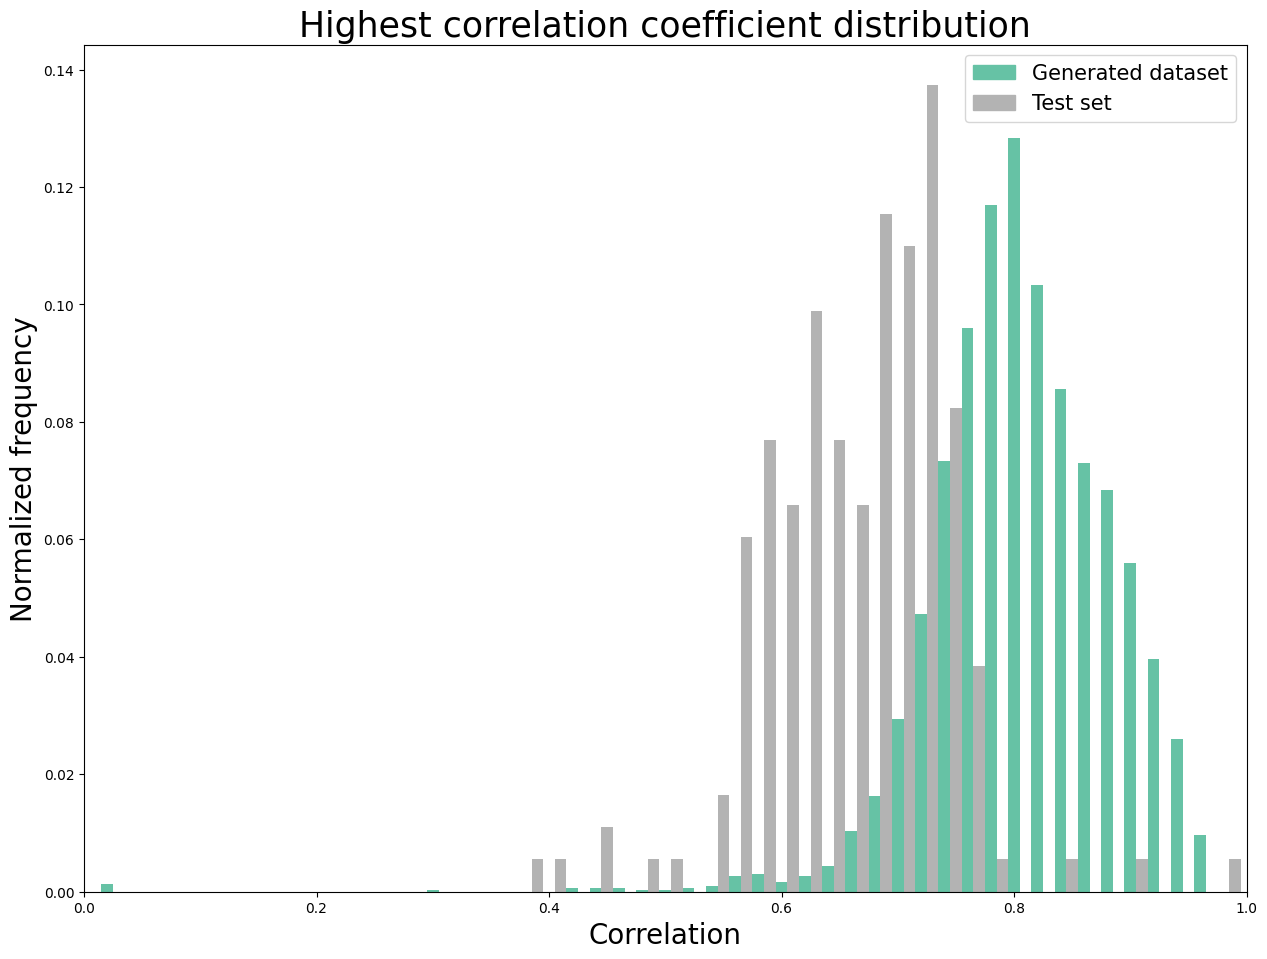

In [105]:
dist_gen, dist_test = draw_corr_hist_plot([max_corr_gen, max_corr_test], ['Generated dataset', 'Test set'], title='Highest correlation coefficient distribution', xlabel='Correlation', r=(0.0, 1))

Secondly, we want to measure the jensen shannon divergence between the two distributions. 
The Jensen-Shannon (JS) divergence is a method of measuring the similarity between two probability distributions. It's symmetric, meaning the JS divergence of P from Q is the same as the JS divergence of Q from P, which is a property not shared by the Kullback-Leibler (KL) divergence.

The JS divergence is defined as the average of the KL divergence of P from the average distribution M, and the KL divergence of Q from the average distribution M, where M is the average of P and Q.

The JS divergence is always between 0 and 1. It's 0 when P and Q are the same, and 1 when P and Q are completely different.

The lower the better.

In [55]:
dist_gen.shape, dist_test.shape, np.sum(dist_gen), np.sum(dist_test)

((51,), (51,), 1.0, 1.0)

In [56]:
jensenshannon(dist_gen, dist_test)

0.636453123977624

## L2 distance

Let's plot also the distribution of the l2 distance to see if we get a similar result w.r.t. the correlation

In [10]:
l2_gen = np.load(f'../memorization/stats/{gen_name}-l2.npy')
l2_test = np.load('../memorization/stats/test-l2.npy')

min_l2_gen = np.min(l2_gen, axis=1)
min_l2_test = np.min(l2_test, axis=1)

print(np.quantile(min_l2_gen, [0.01, 0.05, 0.95, 0.99]))
print(np.quantile(min_l2_test, [0.01, 0.05, 0.95, 0.99]))

[207.03011993 229.38563538 470.49814758 515.33176575]
[245.1895018  408.92443695 591.8652832  619.03816284]


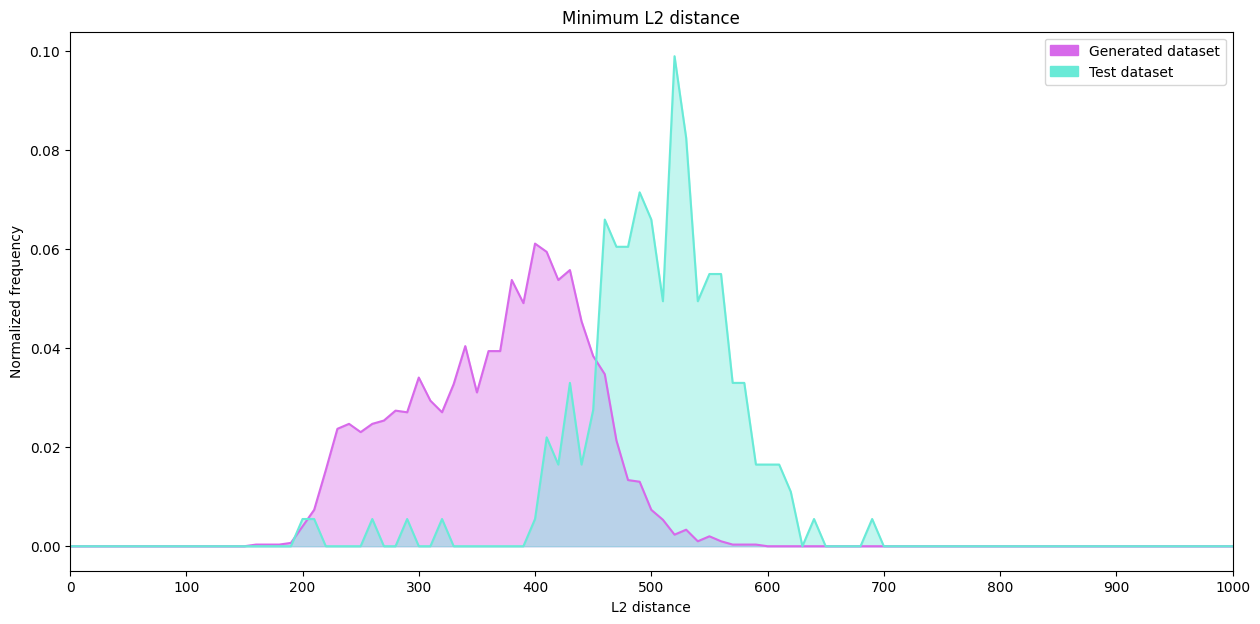

In [11]:
draw_corr_plot([min_l2_gen, min_l2_test], ['Generated dataset', 'Test dataset'], title='Minimum L2 distance', xlabel='L2 distance', r=(0, 1000));

## Lowe's ratio

In order to filter the memorized synthetic examples of the generated dataset, we will use Lowe's ratio test.
Lowe's ratio is a concept used in computer vision, specifically in the SIFT (Scale-Invariant Feature Transform) algorithm for feature matching. 

The ratio is used as a test to find good matches between features. After identifying potential matches for a given feature, the ratio of the distance to the nearest neighbor to the distance to the second-nearest neighbor is computed. If this ratio is below a certain threshold (typically 0.7), the match is considered good. 

This test is based on the observation that true matches usually have a much closer nearest neighbor than the second-nearest.

In this case we are not going to use features to find the matches, but we are going to use the correlations.

In [57]:
idx = np.abs(coeff_gen).argsort(axis=1)[:, -2]
second_max_corr_gen = np.abs(coeff_gen[np.arange(len(coeff_gen)), idx])
idx = np.abs(coeff_test).argsort(axis=1)[:, -2]
second_max_corr_test = np.abs(coeff_test[np.arange(len(coeff_test)), idx])

We can append Lowe's ratio to the generated dataset and to the test dataset

In [58]:
test_dataset = AllCTsDataset(f'../data/allcts-global-128/', split='test')
ratio = second_max_corr_test / max_corr_test
test_dataset.input_df['ratio'] = ratio
test_dataset.input_df


,name,quality,info,split,ratio
5,CTS005,5,*,test,0.897493
7,CTS007,4,*++,test,0.966090
9,CTS009,5,*,test,0.987986
10,CTS010,3,NaN,test,0.883595
11,CTS011,3,NaN,test,0.972908
...,...,...,...,...,...
894,CT468,3,NaN,test,0.982997
897,CT471,2,NaN,test,0.760684
903,CT479,3,NaN,test,0.972029
904,CT480,3,NaN,test,0.925709


In [59]:
dataset = AllCTsDataset(f'../data/{gen_name}/', split='all')
ratio = second_max_corr_gen / max_corr_gen
dataset.input_df['ratio'] = ratio
dataset.input_df['hc1'] = max_corr_gen
dataset.input_df

,name,split,quality,ratio,hc1
0,ctg_0_q2,train,2,0.863734,0.839212
1,ctg_1_q2,train,2,0.868922,0.846713
2,ctg_2_q2,train,2,0.942755,0.734619
3,ctg_3_q2,train,2,0.988276,0.755358
4,ctg_4_q2,train,2,0.994560,0.744571
...,...,...,...,...,...
2995,ctg_639_q5,train,5,0.906438,0.791067
2996,ctg_640_q5,train,5,0.961981,0.792118
2997,ctg_641_q5,train,5,0.877956,0.748831
2998,ctg_642_q5,train,5,0.865206,0.819066


It seems interesting also to plot the distribution of Lowe's ratios in the generated and test set.

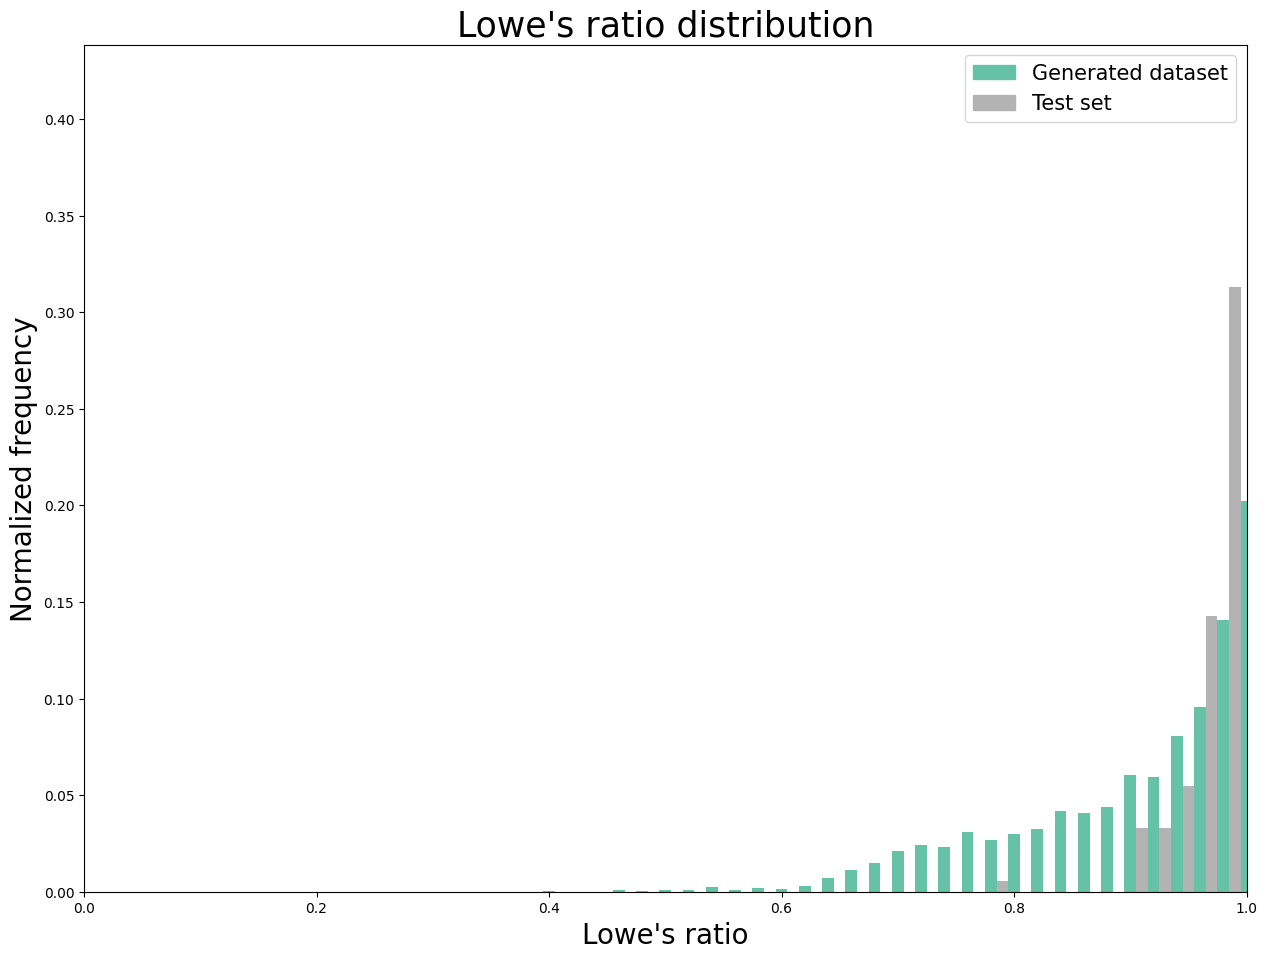

In [60]:
dist_test_lr, dist_dist_lr  = draw_corr_hist_plot([dataset.input_df['ratio'], test_dataset.input_df['ratio']], ['Generated dataset', 'Test set'], r=(0.0,1), title="Lowe's ratio distribution", xlabel="Lowe's ratio")

In [61]:
jensenshannon(dist_test_lr, dist_dist_lr)

0.40370533371560746

## Filtering the dataset

We aim at obtaining a new dataset with the same cardinality and quality distribution as the trainset. We can sort the dataset by descending Lowe's ratio and take the top-k entries 

In [16]:
filtered_df = dataset.input_df.sort_values('ratio', ascending=False).iloc[:727, :]
threshold = filtered_df['ratio'].iloc[-1]
threshold

0.9755288966333803

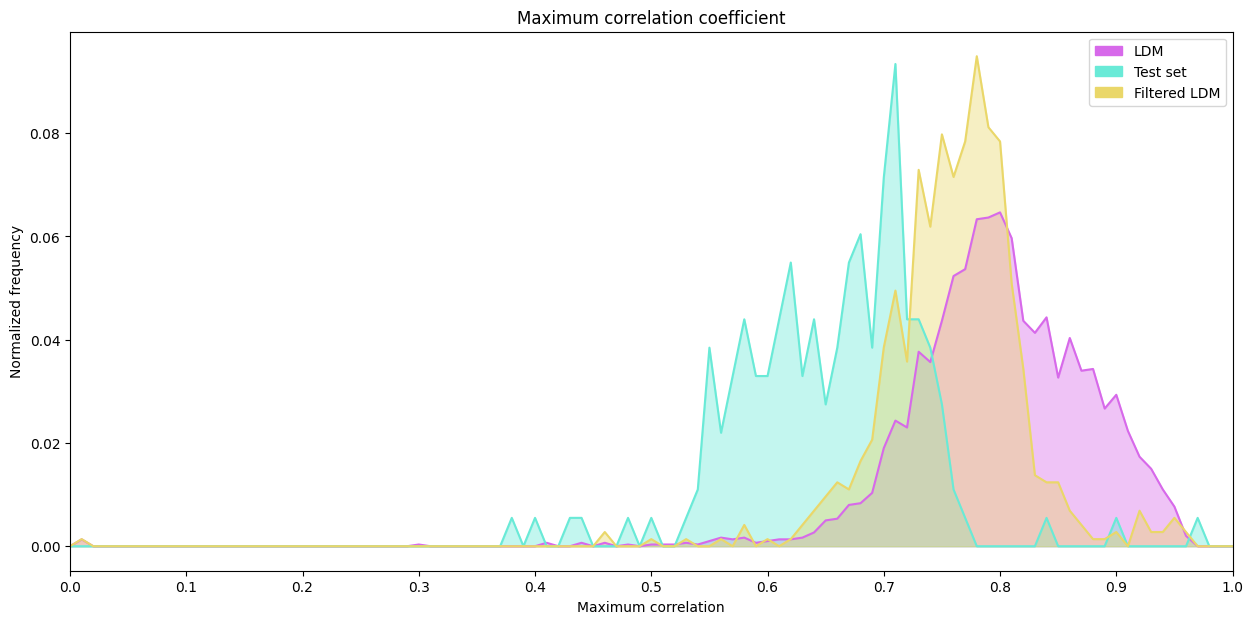

In [17]:
_, _, dist_filt = draw_corr_plot([max_corr_gen, max_corr_test, filtered_df['hc1']], ['LDM', 'Test set', 'Filtered LDM'])

We can also calculate the new jensen shannon divergence for the filtered dataset

In [18]:
jensenshannon(dist_test, dist_filt)

0.5766004485827328

And we can plot the new Lowe's ratio distribution

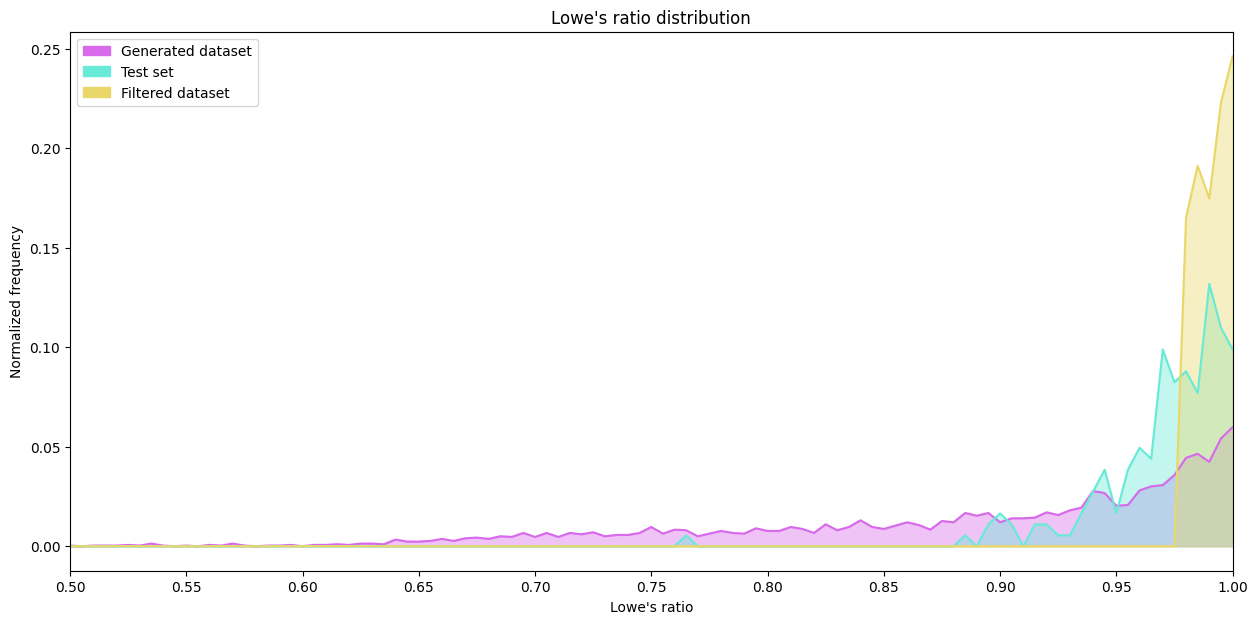

In [19]:
draw_corr_plot([dataset.input_df.ratio, test_dataset.input_df.ratio, filtered_df.ratio], ['Generated dataset', 'Test set', 'Filtered dataset'], r=(0.5,1), title="Lowe's ratio distribution", xlabel="Lowe's ratio");

## Save new metadata for the filtered dataset

In [20]:

dataset_train = AllCTsDataset(f'../data/allcts-global-128/', split='train')
train_df = dataset_train.input_df
# Plot qualities distribution
quality_counts = [filtered_df['quality'].value_counts(), train_df['quality'].value_counts()]
quality_counts

[3    281
 2    200
 4    123
 5    111
 6     12
 Name: quality, dtype: int64,
 3    212
 2    167
 5    156
 4    154
 6     38
 Name: quality, dtype: int64]

In [21]:

from IPython.core.pylabtools import figsize

def plot_quality_dist(quality_counts):
    figsize(15, 7)
    # Set the figure size
    plt.figure(figsize=(15, 7))

    # Define the bar width
    bar_width = 0.35

    # Get the sorted unique qualities
    qualities = sorted(set(quality_counts[0].index).union(quality_counts[1].index))

    # Get the counts for each quality, filling missing qualities with 0
    filtered_counts = [quality_counts[0].get(quality, 0) for quality in qualities]
    original_counts = [quality_counts[1].get(quality, 0) for quality in qualities]

    # Create an index for each group of bars
    index = np.arange(len(qualities))

    # Plot the quality counts for the original data
    plt.bar(index, original_counts, bar_width, color='#69ead7', alpha=0.5, label='train')

    # Plot the quality counts for the filtered data
    plt.bar(index + bar_width, filtered_counts, bar_width, color='#ead769', alpha=0.5, label='filtered')

    # Add gridlines
    plt.grid(linewidth=0.2)

    # Add labels and title
    plt.xlabel('Quality', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Quality Distribution', fontsize=14)

    # Add xticks in the middle of the group bars
    plt.xticks(index + bar_width / 2, qualities)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

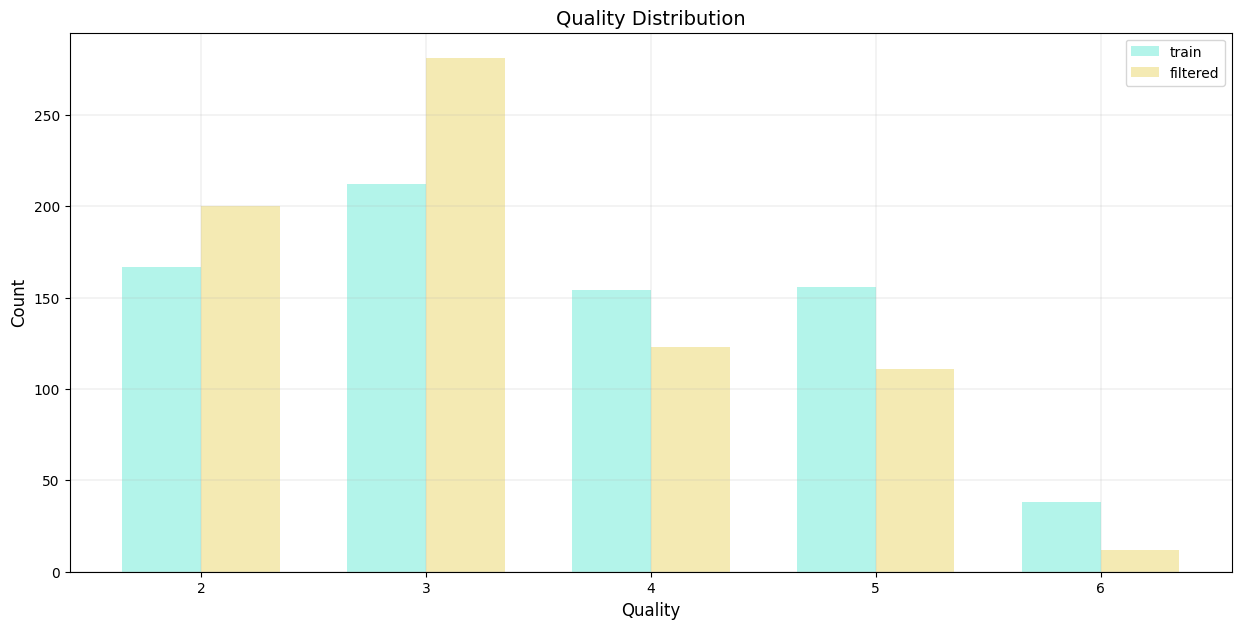

In [22]:
plot_quality_dist(quality_counts)

Lastly, we can save the filtered metadata as csv

In [23]:
filtered_df.to_csv(f'../data/{gen_name}/filtered.csv', index=False)

## Per quality filtering

We can observe that when we select a global treshold we end up changing the distribution of the original dataset. The problem is that this change is favouring the qualities that were already more present and it makes the qs that were rare even more so.

We can solve this issue by selecting a threshold independently for each qs. The aim is, for each qs, to find a threshold that will bring the number of example of that class equal to the quantity found in the training set.

In [24]:
dataset.input_df.quantile(np.arange(0, 0.1, 0.001))

,quality,ratio,hc1
0.000,2.0,0.395842,0.003624
0.001,2.0,0.477849,0.004681
0.002,2.0,0.497907,0.409488
0.003,2.0,0.516980,0.452933
0.004,2.0,0.528085,0.499256
...,...,...,...
0.095,2.0,0.721882,0.707843
0.096,2.0,0.722630,0.708396
0.097,2.0,0.723452,0.708765
0.098,2.0,0.725216,0.708968


In [25]:
groups = dataset.input_df.groupby('quality')
train_counts = train_df['quality'].value_counts()
refiltered_df = pd.DataFrame()

for name, group in groups:
    counts = train_counts[name]
    group = group.sort_values('ratio', ascending=False)
    group = group.loc[group['hc1']>0.409488]
    group = group.iloc[:counts, :]
    print(group.tail(1))
    refiltered_df = pd.concat([refiltered_df, group])

           name  split  quality     ratio       hc1
176  ctg_176_q2  train        2  0.980496  0.704466
            name  split  quality     ratio       hc1
1091  ctg_402_q3  train        3  0.982691  0.824466
            name  split  quality     ratio       hc1
1876  ctg_312_q4  train        4  0.965071  0.743474
            name  split  quality     ratio       hc1
2645  ctg_289_q5  train        5  0.963642  0.695818
            name  split  quality     ratio       hc1
2312  ctg_113_q6  train        6  0.889024  0.613079


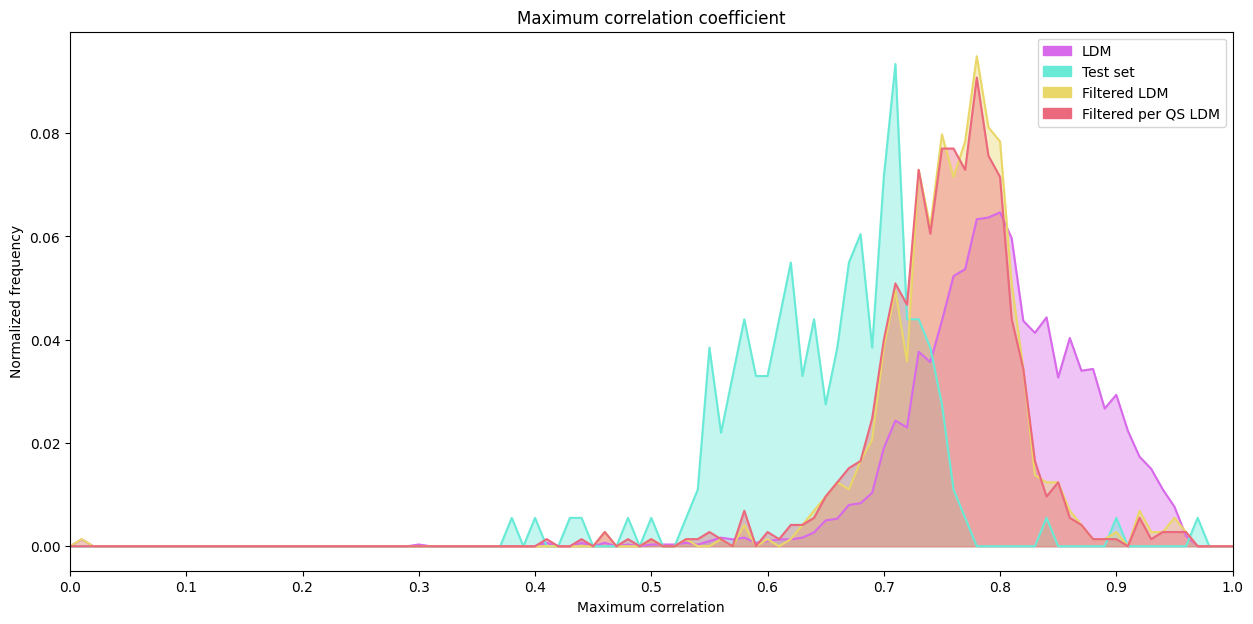

In [26]:
_, _, _, dist_filt = draw_corr_plot([max_corr_gen, max_corr_test, filtered_df.hc1, refiltered_df.hc1], ['LDM', 'Test set', 'Filtered LDM', 'Filtered per QS LDM'])

In [27]:
jensenshannon(dist_test, dist_filt)

0.5496004346806985

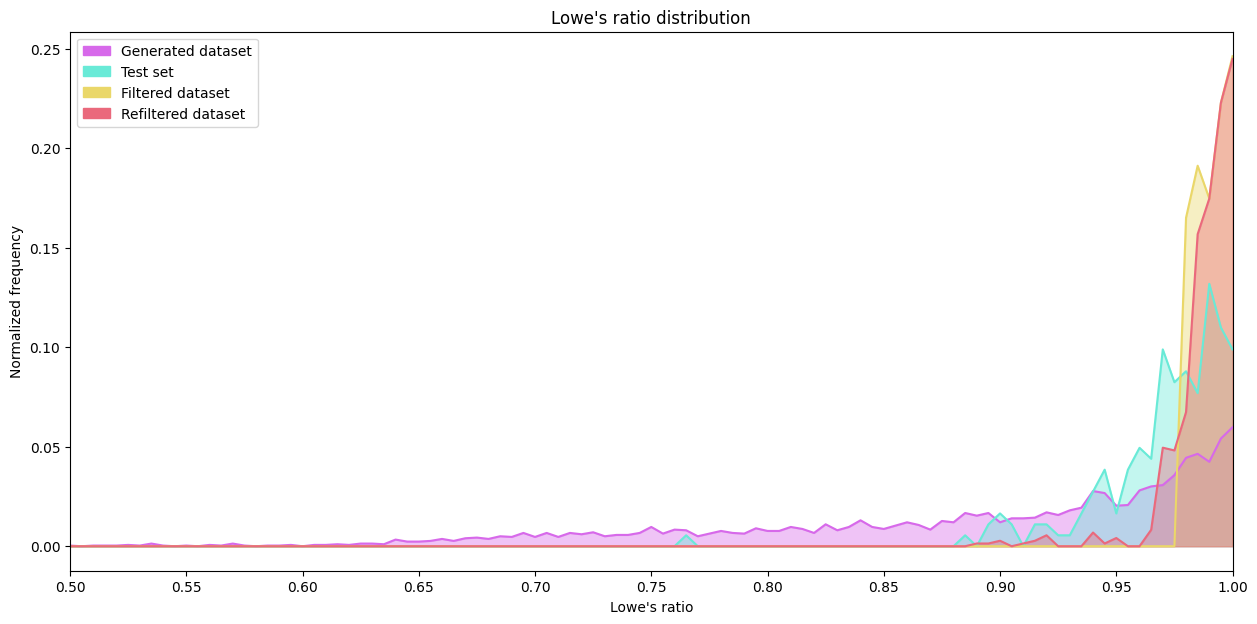

In [28]:
draw_corr_plot([dataset.input_df.ratio, test_dataset.input_df.ratio, filtered_df.ratio, refiltered_df.ratio], ['Generated dataset', 'Test set', 'Filtered dataset', 'Refiltered dataset'], r=(0.5,1), title="Lowe's ratio distribution", xlabel="Lowe's ratio");

In [29]:
quality_counts = [refiltered_df['quality'].value_counts(), train_df['quality'].value_counts()]
quality_counts


[3    212
 2    167
 5    156
 4    154
 6     38
 Name: quality, dtype: int64,
 3    212
 2    167
 5    156
 4    154
 6     38
 Name: quality, dtype: int64]

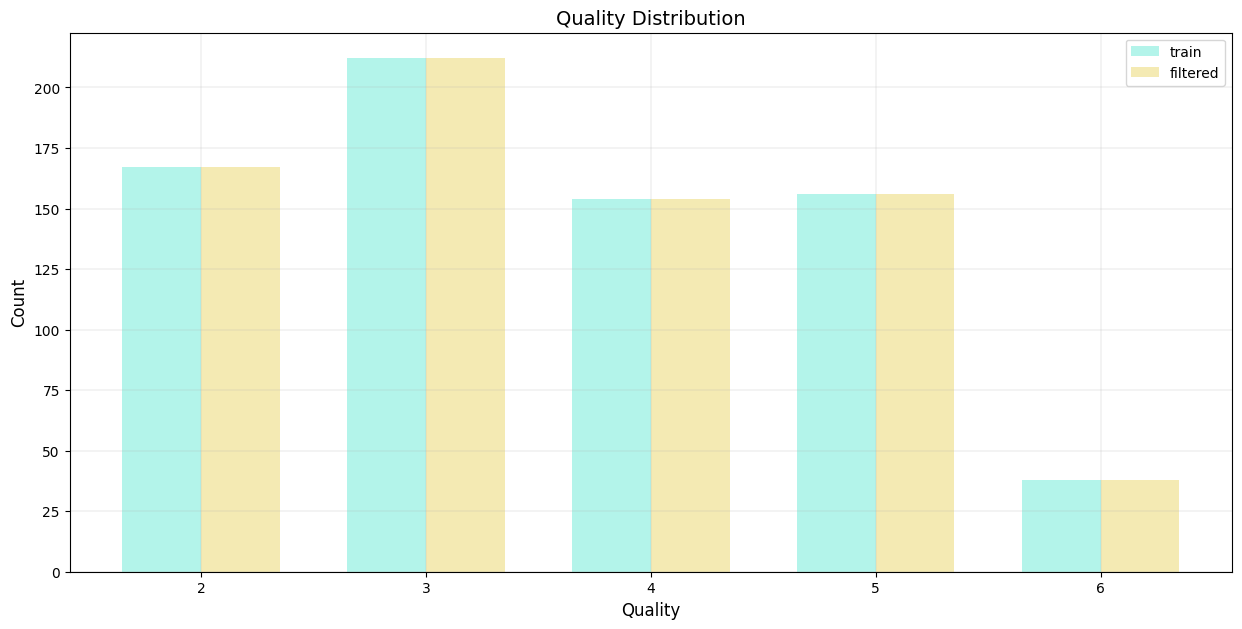

In [30]:
plot_quality_dist(quality_counts)

In [31]:
refiltered_df.to_csv(f'../data/{gen_name}/refiltered.csv', index=False)

## Filtering with test Lowe's ratio

We have seen from the plot of the Lowe's ratio distribution in the generated and filtered dataset that by selecting the top-k entries we are cutting many possible non-copies. This could possibly influence the diversity of the distilled dataset. Let us try to keep all the examples which are not considered copies based on the Lowe's ratio of the test set. As we did before, we will keep distinct values for the different qualities as they show different characteristics.

First we look at the quantiles of the ratios in the whole test dataset

In [37]:
# Compute quantiles of the ratio
test_dataset.input_df['ratio'].quantile(np.arange(0, 0.2, 0.01))

0.00    0.760684
0.01    0.891877
0.02    0.895283
0.03    0.896556
0.04    0.900992
0.05    0.912944
0.06    0.917145
0.07    0.920884
0.08    0.928060
0.09    0.931986
0.10    0.936050
0.11    0.938742
0.12    0.939497
0.13    0.940479
0.14    0.941261
0.15    0.942540
0.16    0.944750
0.17    0.948151
0.18    0.950063
0.19    0.953264
Name: ratio, dtype: float64

Secondly, we can look at the quantiles when we group the dataset by quality

In [38]:
ratios = {}
for name, group in test_dataset.input_df.groupby('quality'):
    print(f'QUALITY {name}'), 
    quantiles = group['ratio'].quantile([0.00, 0.05, 0.05, 0.1])
    ratios[str(name)] = quantiles.iloc[1]
    print(quantiles)

QUALITY 2
0.00    0.760684
0.05    0.939508
0.05    0.939508
0.10    0.941639
Name: ratio, dtype: float64
QUALITY 3
0.00    0.883595
0.05    0.911597
0.05    0.911597
0.10    0.932233
Name: ratio, dtype: float64
QUALITY 4
0.00    0.893819
0.05    0.902497
0.05    0.902497
0.10    0.918064
Name: ratio, dtype: float64
QUALITY 5
0.00    0.895849
0.05    0.911380
0.05    0.911380
0.10    0.929586
Name: ratio, dtype: float64
QUALITY 6
0.00    0.930608
0.05    0.934826
0.05    0.934826
0.10    0.939045
Name: ratio, dtype: float64


We could take, for each quality, all the examples which have Lowe's ratio greater than the 0.05 quantile of the ratios in the test set.

In [39]:
ratios

{'2': 0.9395083086492726,
 '3': 0.911596794526913,
 '4': 0.902497175148654,
 '5': 0.9113799090709169,
 '6': 0.9348260870503159}

In [137]:
combo_dataset = pd.read_csv('../data/gen-05-bis/metadata.csv')
coeff_combo = np.load(f'../memorization/stats/{gen_name}-bis-corr.npy')
max_corr_combo = np.max(np.abs(coeff_combo), axis=1)
idx = np.abs(coeff_combo).argsort(axis=1)[:, -2]
second_max_corr_combo = np.abs(coeff_combo[np.arange(len(coeff_combo)), idx])
ratio_combo = second_max_corr_combo / max_corr_combo
combo_dataset['ratio'] = ratio_combo
combo_dataset = pd.concat([dataset.input_df, combo_dataset])
combo_dataset.shape


(3300, 5)

In [148]:
threshold = test_dataset.input_df['ratio'].quantile(0.005)
threshold

0.871918050535819

In [149]:
combo_dataset = dataset.input_df

In [150]:
combo_dataset = combo_dataset[combo_dataset['ratio'] > threshold]
combo_dataset.shape

(1976, 5)

In [151]:
groups = combo_dataset.groupby('quality')
train_counts = train_df['quality'].value_counts()
filtered_df_3 = pd.DataFrame()

for name, group in groups:
    counts = train_counts[name]
    group = group.loc[group['hc1']>0.409488]
    group = group.iloc[:counts, :]
    filtered_df_3 = pd.concat([filtered_df_3, group])

In [152]:
filtered_df_3.shape

(727, 5)

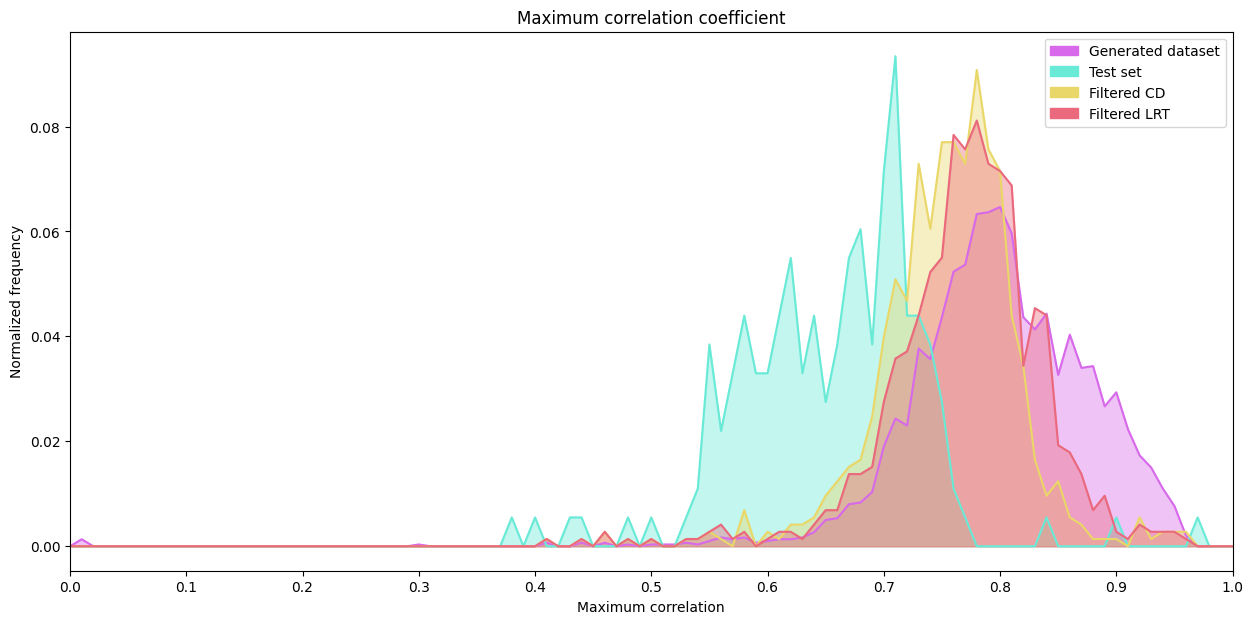

In [142]:
_, _, _, filtered_lrt_dist = draw_corr_plot([max_corr_gen, max_corr_test, refiltered_df.hc1, filtered_df_3.hc1], ['Generated dataset', 'Test set', 'Filtered CD', 'Filtered LRT'])

In [143]:
jensenshannon(dist_test, filtered_lrt_dist)

0.5929343775838026

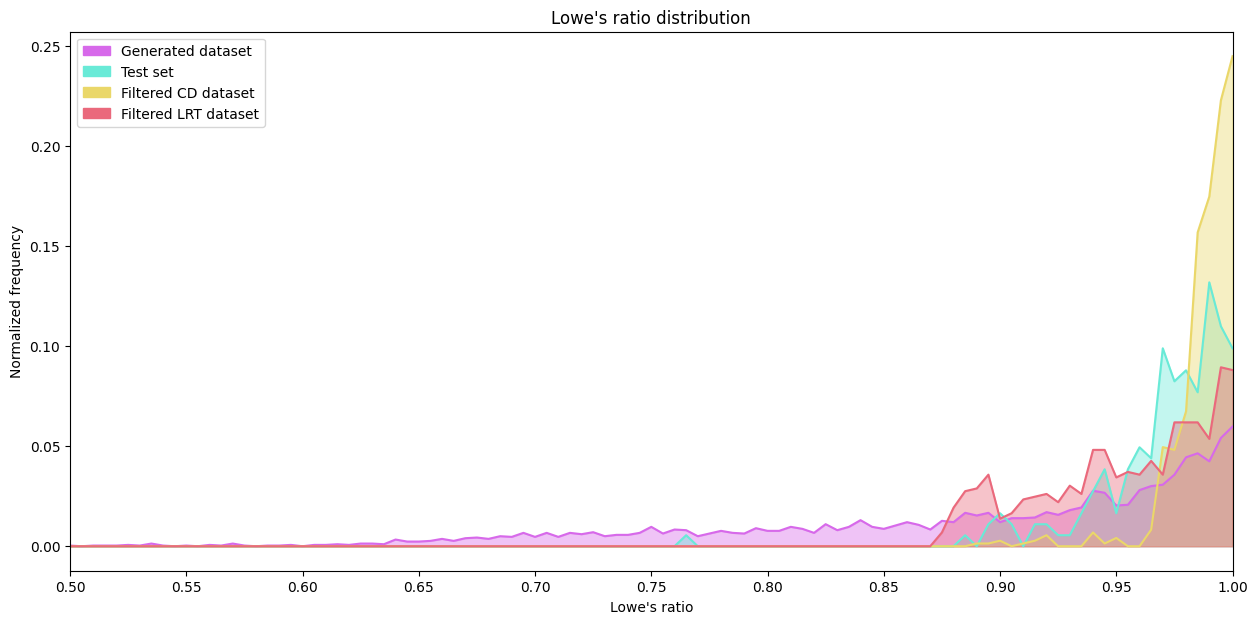

In [144]:
draw_corr_plot([dataset.input_df.ratio, test_dataset.input_df.ratio, refiltered_df.ratio, filtered_df_3.ratio], ['Generated dataset', 'Test set', 'Filtered CD dataset', 'Filtered LRT dataset'], r=(0.5,1), title="Lowe's ratio distribution", xlabel="Lowe's ratio");

As we can see we have that the distributions in the test and in the filtered LRT datasets are very similar! Let us see how this changes the quality distribution w.r.t. the one in the training set. 

In [145]:
quality_counts = [filtered_df_3['quality'].value_counts(), train_df['quality'].value_counts()]
quality_counts

[3    212
 2    167
 5    156
 4    154
 6     38
 Name: quality, dtype: int64,
 3    212
 2    167
 5    156
 4    154
 6     38
 Name: quality, dtype: int64]

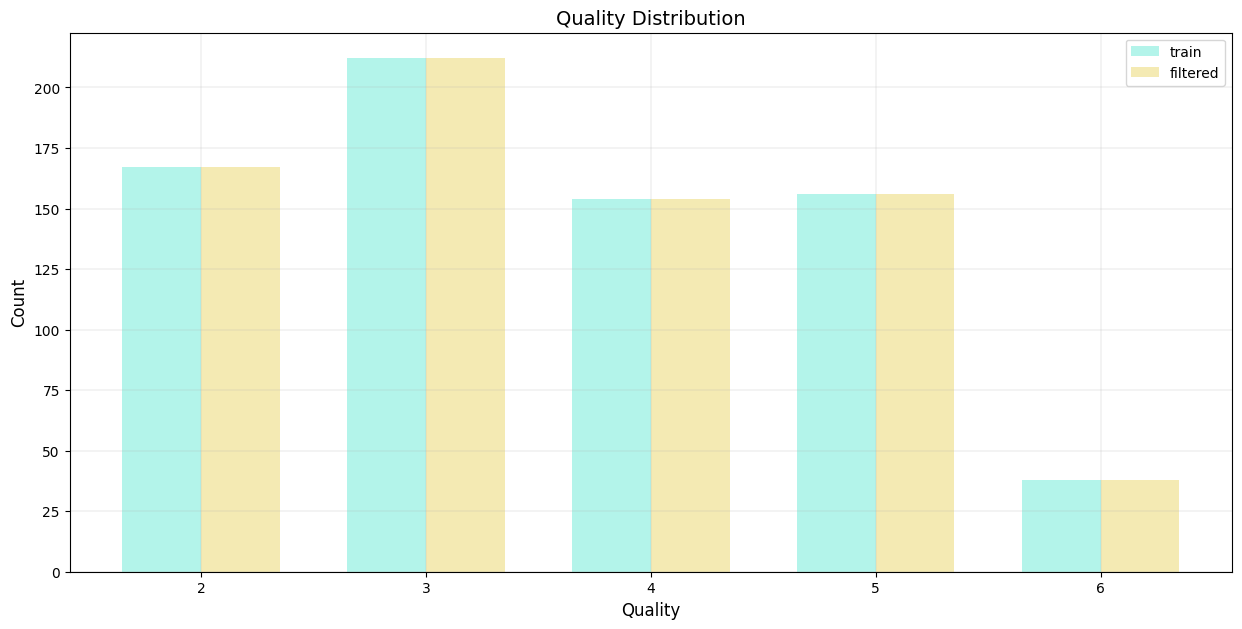

In [146]:
plot_quality_dist(quality_counts)

In [147]:
filtered_df_3.to_csv(f'../data/{gen_name}/filtered_lrt.csv', index=False)

## Filter with correlation threshold

In [78]:
np.quantile(max_corr_test, [0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.985, 0.99])

array([0.70709922, 0.72834066, 0.74403725, 0.74711095, 0.75523896,
       0.7613546 , 0.78415564, 0.84518342])

In [95]:
threshold = np.quantile(max_corr_test, 0.983)
threshold

0.7639856095910073

In [93]:
filtered_df_corr = dataset.input_df.loc[dataset.input_df['hc1'] <= threshold]
filtered_df_corr = filtered_df_corr.loc[filtered_df_corr['hc1']>0.409488]
filtered_df_corr

,name,split,quality,ratio,hc1
2,ctg_2_q2,train,2,0.942755,0.734619
3,ctg_3_q2,train,2,0.988276,0.755358
4,ctg_4_q2,train,2,0.994560,0.744571
7,ctg_7_q2,train,2,0.983409,0.761626
17,ctg_17_q2,train,2,0.986249,0.726916
...,...,...,...,...,...
2982,ctg_626_q5,train,5,0.964713,0.709849
2986,ctg_630_q5,train,5,0.955543,0.679030
2993,ctg_637_q5,train,5,0.957428,0.740086
2997,ctg_641_q5,train,5,0.877956,0.748831


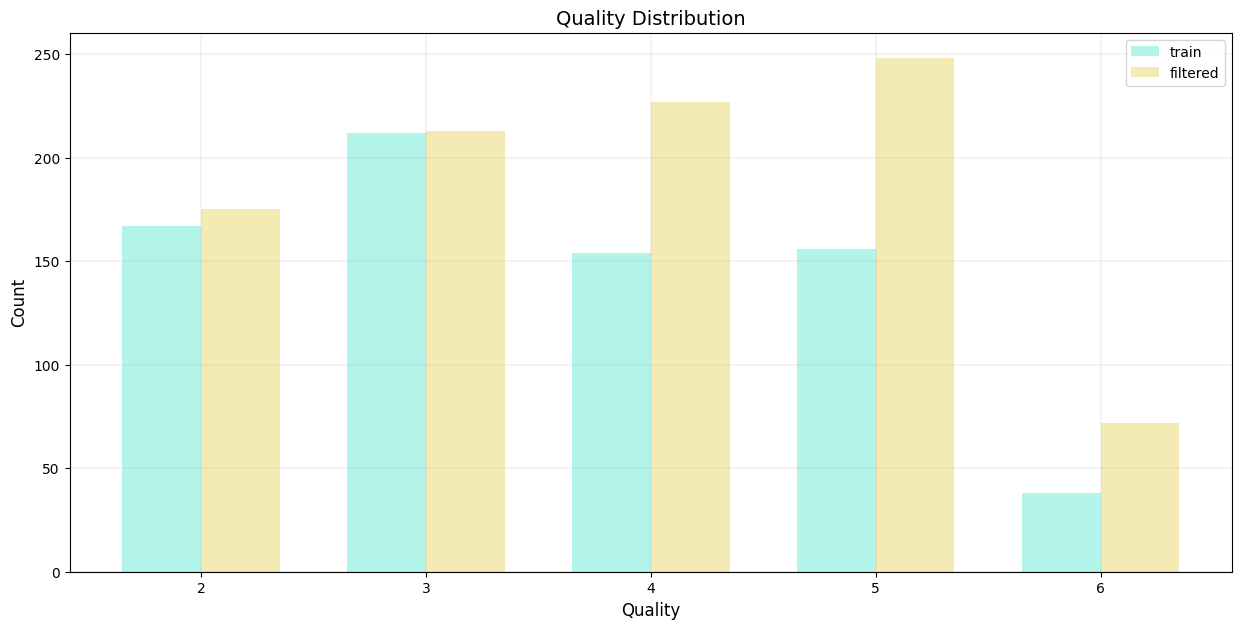

In [94]:
quality_counts = [filtered_df_corr['quality'].value_counts(), train_df['quality'].value_counts()]
plot_quality_dist(quality_counts)

Let us keep only the first k to match the training set cardinality

In [98]:
# keep only first k samples of each quality
groups = filtered_df_corr.groupby('quality')
train_counts = train_df['quality'].value_counts()
filtered_df_corr_2 = pd.DataFrame()
for name, group in groups:
    counts = train_counts[name]
    group = group.iloc[:counts, :]
    filtered_df_corr_2 = pd.concat([filtered_df_corr_2, group])

filtered_df_corr_2

,name,split,quality,ratio,hc1
2,ctg_2_q2,train,2,0.942755,0.734619
3,ctg_3_q2,train,2,0.988276,0.755358
4,ctg_4_q2,train,2,0.994560,0.744571
7,ctg_7_q2,train,2,0.983409,0.761626
17,ctg_17_q2,train,2,0.986249,0.726916
...,...,...,...,...,...
2269,ctg_70_q6,train,6,0.969511,0.573025
2270,ctg_71_q6,train,6,0.990882,0.750308
2271,ctg_72_q6,train,6,0.638149,0.752803
2272,ctg_73_q6,train,6,0.973763,0.542380


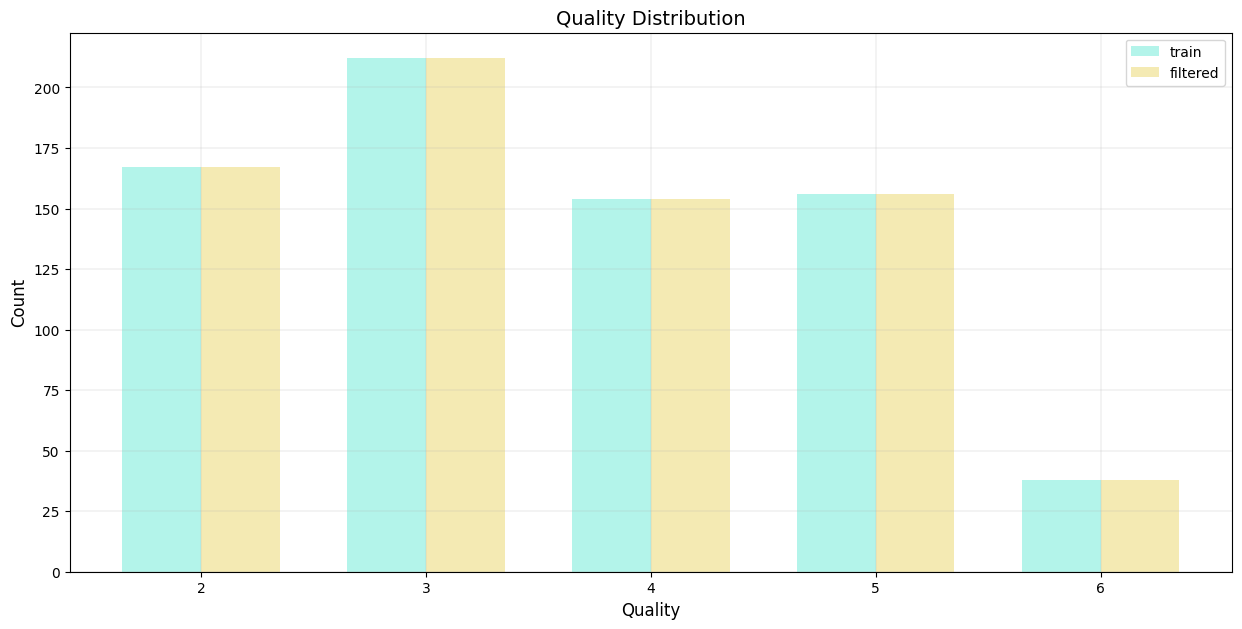

In [99]:
quality_counts = [filtered_df_corr_2['quality'].value_counts(), train_df['quality'].value_counts()]
plot_quality_dist(quality_counts)

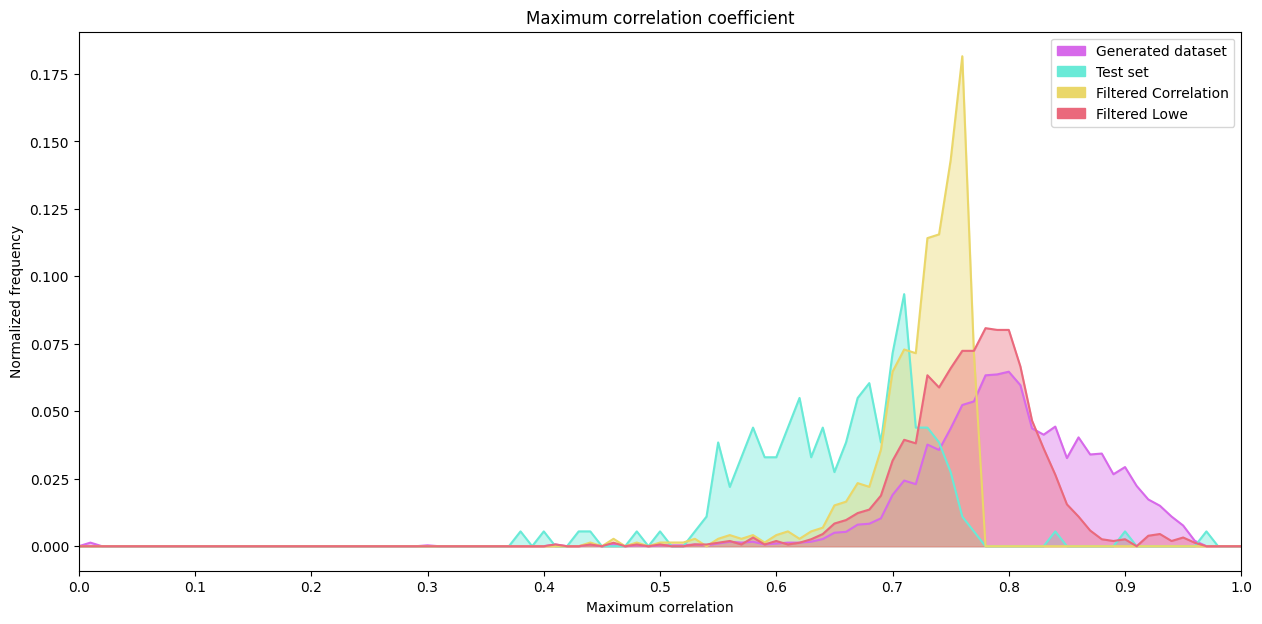

In [108]:
_, _, filtered_corr_dist = draw_corr_plot([max_corr_gen, max_corr_test, filtered_df_corr_2.hc1], ['Generated dataset', 'Test set', 'Filtered Correlation'])

In [101]:
jensenshannon(dist_test, filtered_corr_dist)

0.46478718833040966

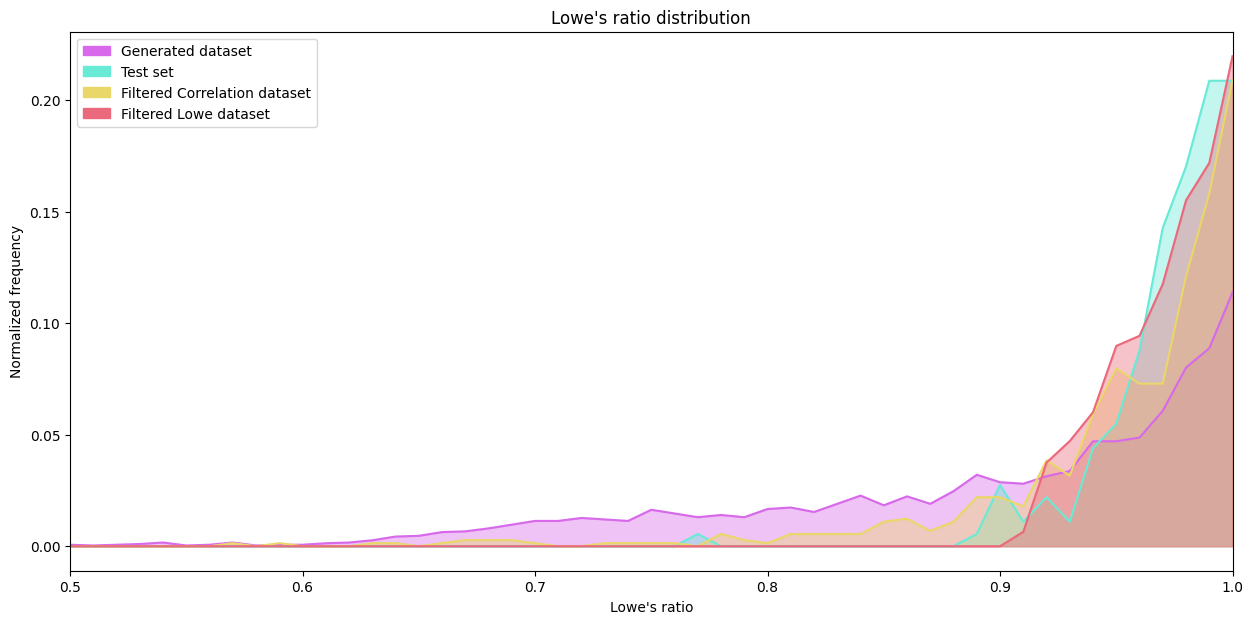

In [109]:
draw_corr_plot([dataset.input_df.ratio, test_dataset.input_df.ratio, filtered_df_corr_2.ratio, filtered_df_3.ratio], ['Generated dataset', 'Test set', 'Filtered Correlation dataset', 'Filtered Lowe dataset'], r=(0.5,1), title="Lowe's ratio distribution", xlabel="Lowe's ratio");

In [110]:
filtered_df_corr_2.to_csv(f'../data/{gen_name}/filtered_corr.csv', index=False)

## Testing effect of generated dataset cardinality

In [106]:
groups = dataset.input_df.groupby('quality')
test_counts = test_dataset.input_df['quality'].value_counts()
test_cardinality_df = pd.DataFrame()
for name, group in groups:
    counts = test_counts[name]
    group = group.iloc[:counts, :]
    test_cardinality_df = pd.concat([test_cardinality_df, group])

test_cardinality_df

,name,split,quality,ratio,hc1
0,ctg_0_q2,train,2,0.863734,0.839212
1,ctg_1_q2,train,2,0.868922,0.846713
2,ctg_2_q2,train,2,0.942755,0.734619
3,ctg_3_q2,train,2,0.988276,0.755358
4,ctg_4_q2,train,2,0.994560,0.744571
...,...,...,...,...,...
2203,ctg_4_q6,train,6,0.528100,0.895010
2204,ctg_5_q6,train,6,0.825185,0.566632
2205,ctg_6_q6,train,6,0.530644,0.822897
2206,ctg_7_q6,train,6,0.676107,0.814031


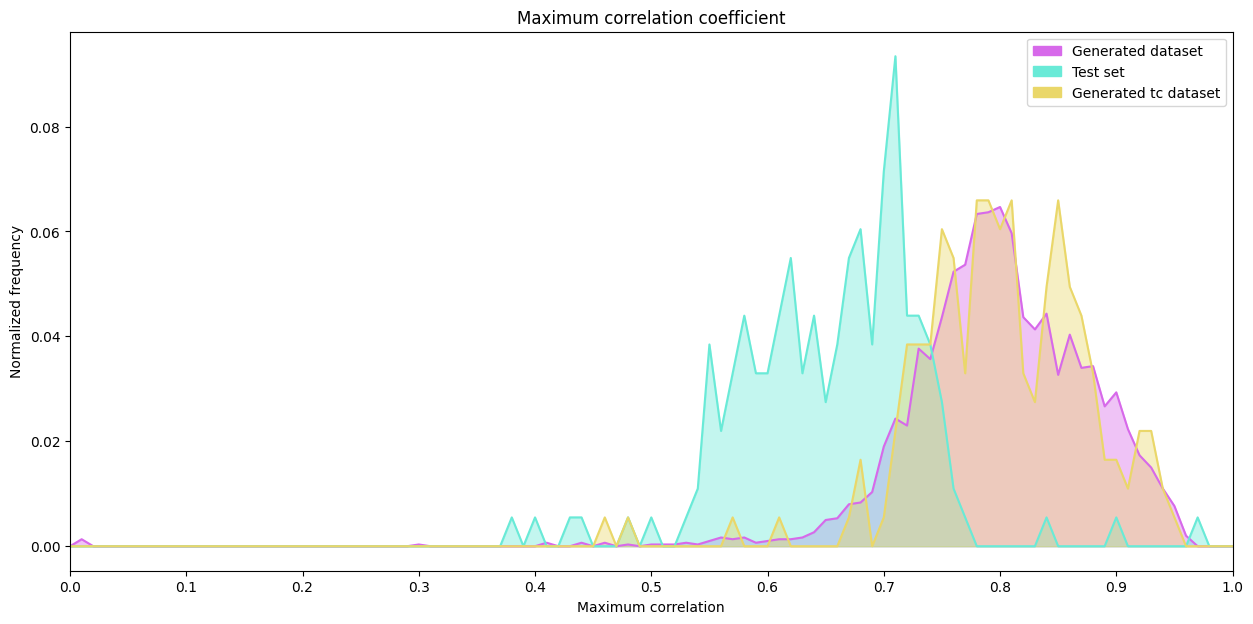

In [107]:
_, _, filtered_corr_dist = draw_corr_plot([max_corr_gen, max_corr_test, test_cardinality_df.hc1], ['Generated dataset', 'Test set', 'Generated tc dataset'])

# Distilled memorization analysis

## Dist top-k Lowe's ratio

In [62]:
dist_name = 'dist-cd-05'

In [63]:
coeff_dist = np.load(f'../memorization/stats/{dist_name}-corr.npy')


mean_corr_dist = np.mean(np.abs(coeff_dist), axis=1)
max_corr_dist = np.max(np.abs(coeff_dist), axis=1)

idx = np.abs(coeff_dist).argsort(axis=1)[:, -2]
second_max_corr_dist = np.abs(coeff_dist[np.arange(len(coeff_dist)), idx])

ratio_dist = second_max_corr_dist / max_corr_dist

coeff_dist.shape, mean_corr_dist.shape, max_corr_dist.shape, second_max_corr_dist.shape, ratio_dist.shape

((3000, 727), (3000,), (3000,), (3000,), (3000,))

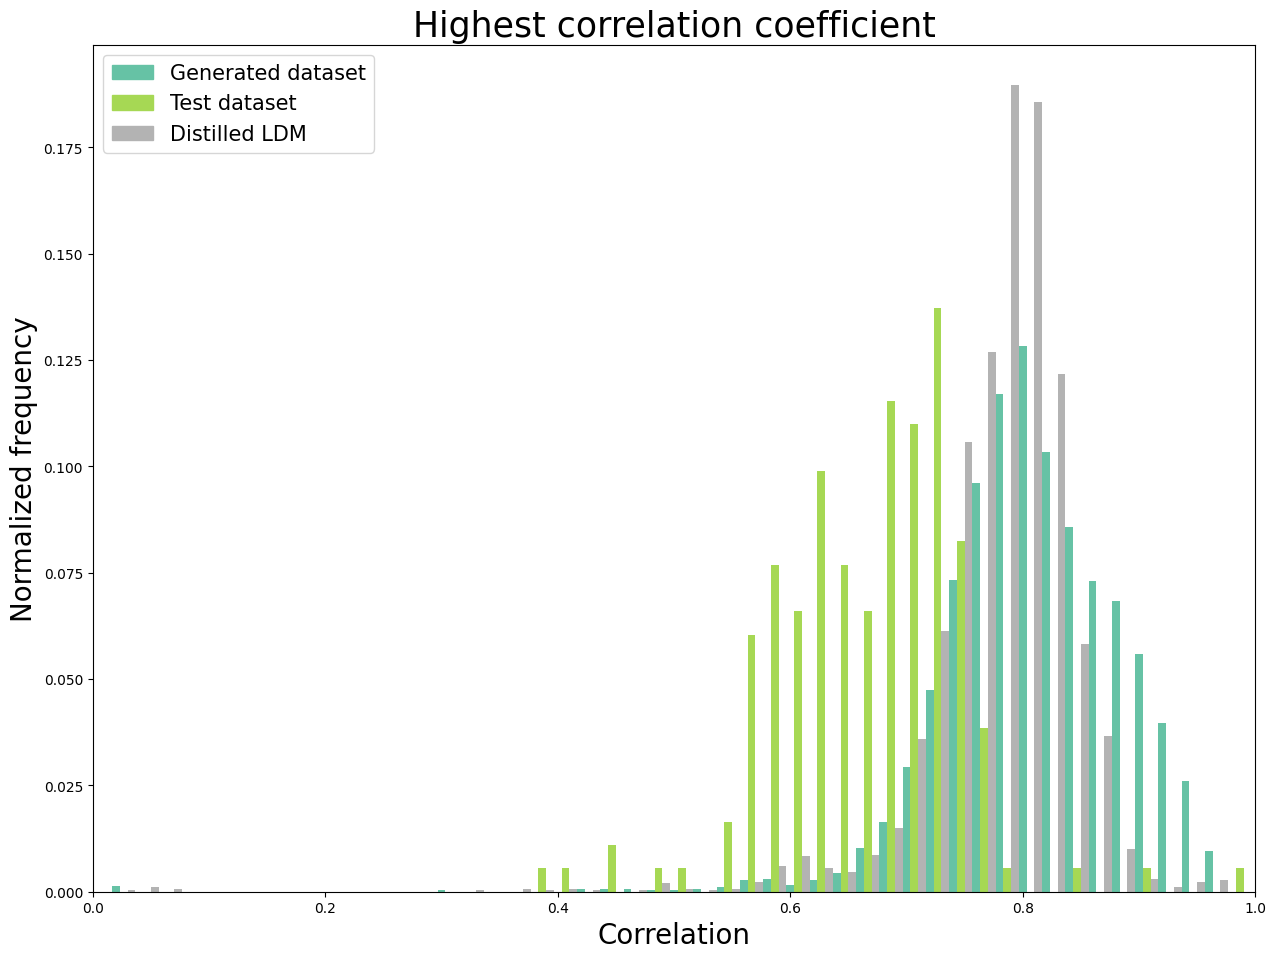

In [64]:
_, _, dist_dist = draw_corr_hist_plot([max_corr_gen, max_corr_test, max_corr_dist], ['Generated dataset', 'Test dataset', 'Distilled LDM'])

In [65]:
jensenshannon(dist_test, dist_dist)

0.6043827873545209

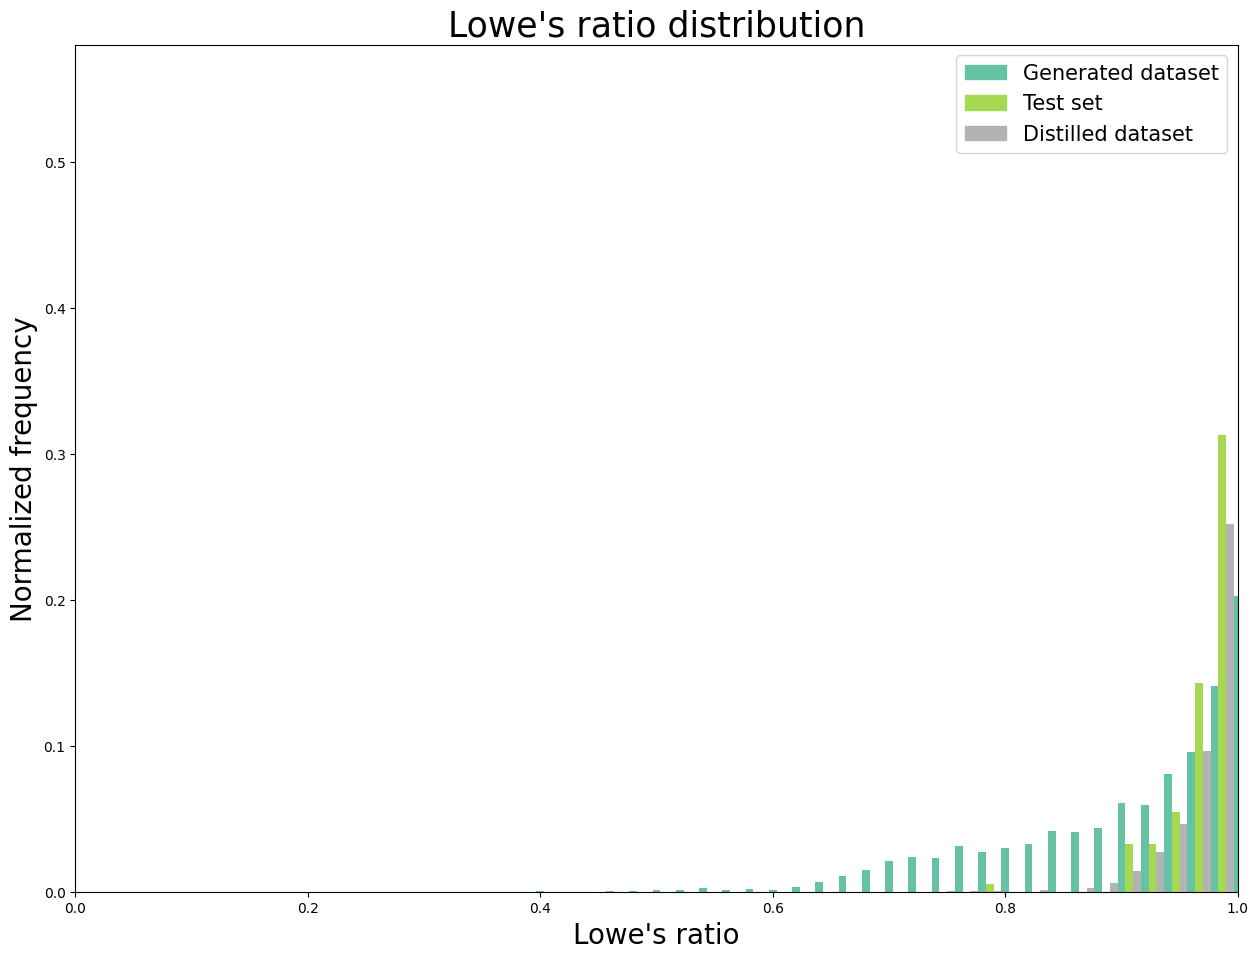

In [66]:
_, dist_test_lr, dist_dist_lr = draw_corr_hist_plot([dataset.input_df.ratio, test_dataset.input_df.ratio, ratio_dist], ['Generated dataset', 'Test set', 'Distilled dataset'], r=(0.0,1), title="Lowe's ratio distribution", xlabel="Lowe's ratio")

In [67]:
jensenshannon(dist_test_lr, dist_dist_lr)

0.12510208012657195

## Dist Lowe's ratio threshold

In [68]:
dist_name = 'dist-lrt-05'
coeff_dist_lrt = np.load(f'../memorization/stats/{dist_name}-corr.npy')


max_corr_dist_lrt = np.max(np.abs(coeff_dist_lrt), axis=1)

idx = np.abs(coeff_dist_lrt).argsort(axis=1)[:, -2]
second_max_corr_dist_lrt = np.abs(coeff_dist_lrt[np.arange(len(coeff_dist_lrt)), idx])

ratio_dist_lrt = second_max_corr_dist_lrt / max_corr_dist_lrt

coeff_dist_lrt.shape, max_corr_dist_lrt.shape, second_max_corr_dist_lrt.shape, ratio_dist_lrt.shape

((727, 727), (727,), (727,), (727,))

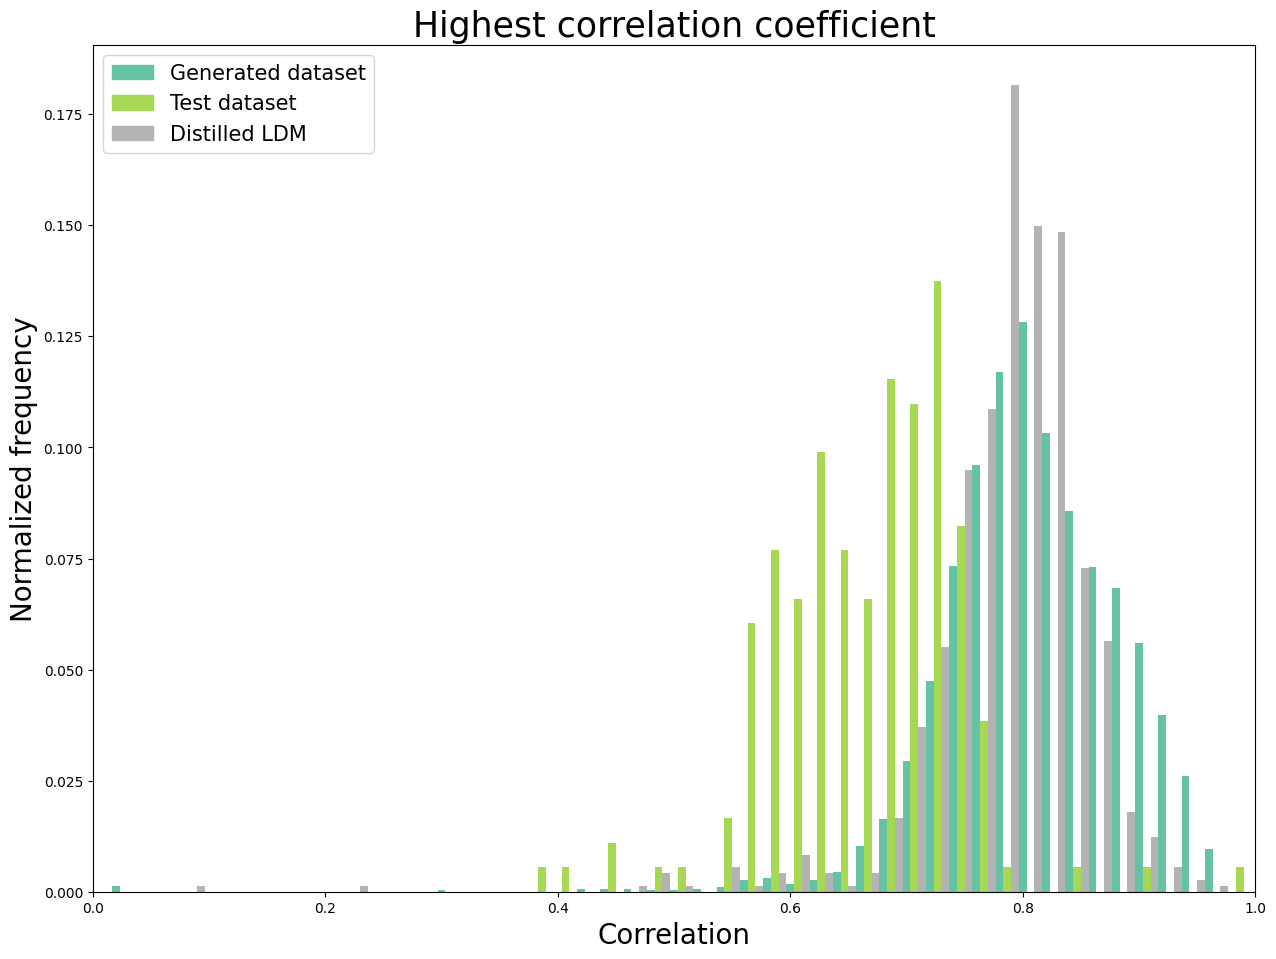

In [69]:
_, _, dist_dist = draw_corr_hist_plot([max_corr_gen, max_corr_test, max_corr_dist_lrt], ['Generated dataset', 'Test dataset', 'Distilled LDM'])

In [70]:
jensenshannon(dist_test, dist_dist)

0.6182545105627887

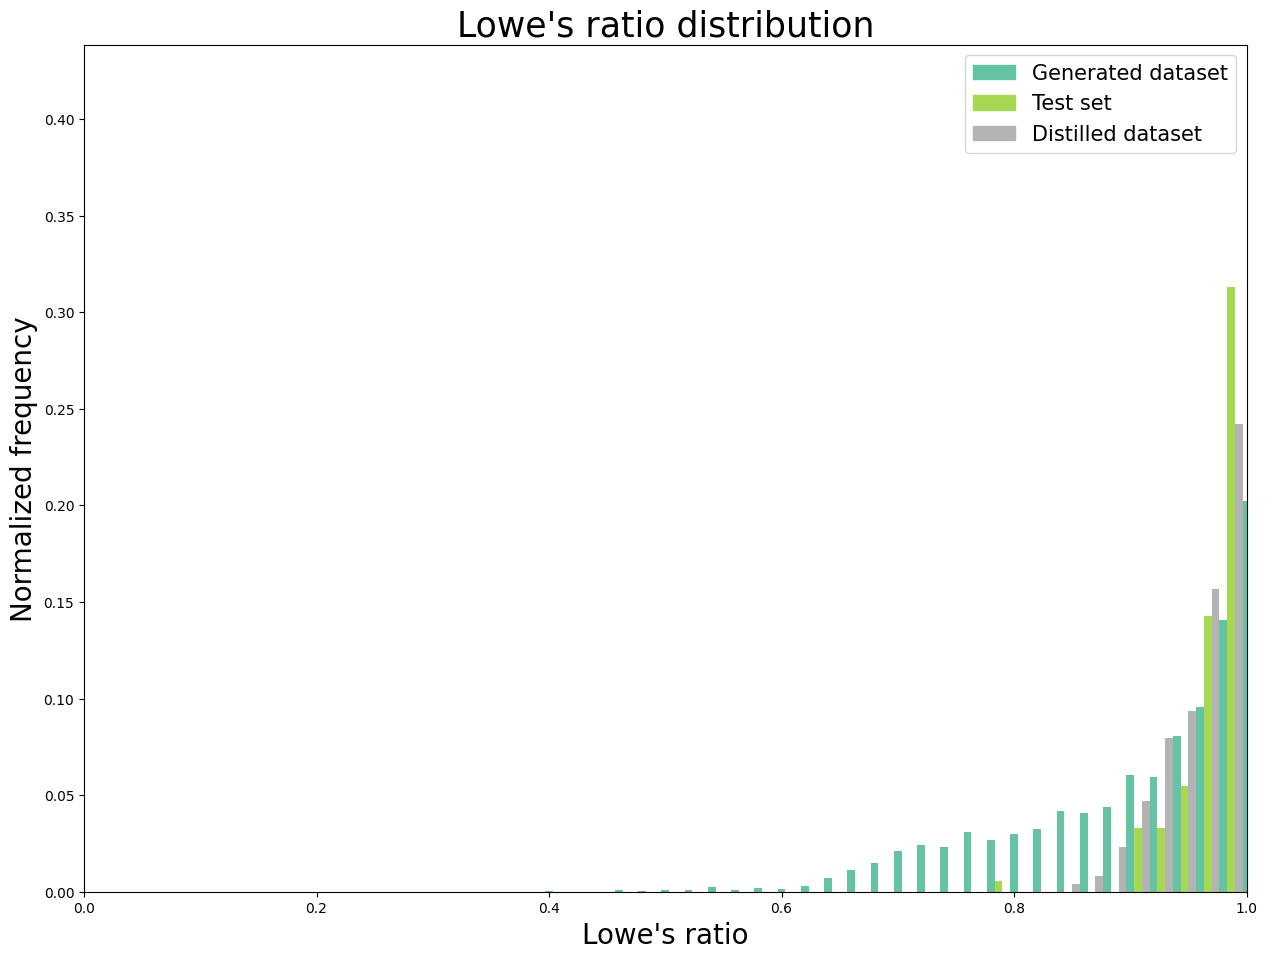

In [71]:
_, dist_test_lr, dist_dist_lr = draw_corr_hist_plot([dataset.input_df.ratio, test_dataset.input_df.ratio, ratio_dist_lrt], ['Generated dataset', 'Test set', 'Distilled dataset'], r=(0.0,1), title="Lowe's ratio distribution", xlabel="Lowe's ratio");

In [72]:
jensenshannon(dist_test_lr, dist_dist_lr)

0.16311462761428838

## Dist corr threshold

In [73]:
dist_name = 'dist-corr-05'
coeff_dist_corr = np.load(f'../memorization/stats/{dist_name}-corr.npy')


max_corr_dist_corr = np.max(np.abs(coeff_dist_corr), axis=1)

idx = np.abs(coeff_dist_corr).argsort(axis=1)[:, -2]
second_max_corr_dist_corr = np.abs(coeff_dist_corr[np.arange(len(coeff_dist_corr)), idx])

ratio_dist_corr = second_max_corr_dist_corr / max_corr_dist_corr

coeff_dist_corr.shape, max_corr_dist_corr.shape, second_max_corr_dist_corr.shape, ratio_dist_corr.shape

((727, 727), (727,), (727,), (727,))

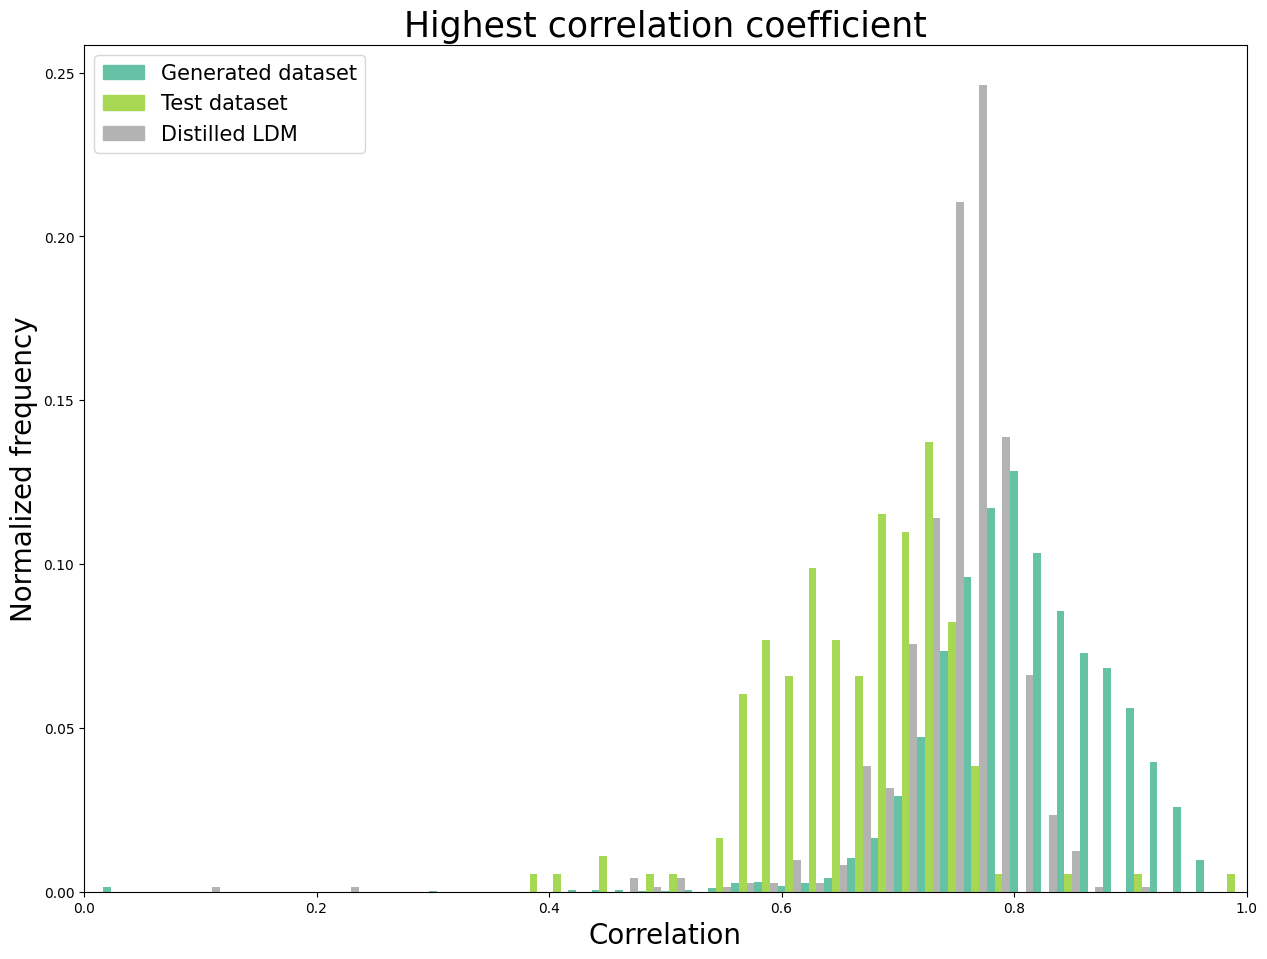

In [74]:
_, _, dist_dist = draw_corr_hist_plot([max_corr_gen, max_corr_test, max_corr_dist_corr], ['Generated dataset', 'Test dataset', 'Distilled LDM'])

In [75]:
jensenshannon(dist_test, dist_dist)

0.5054551353865151

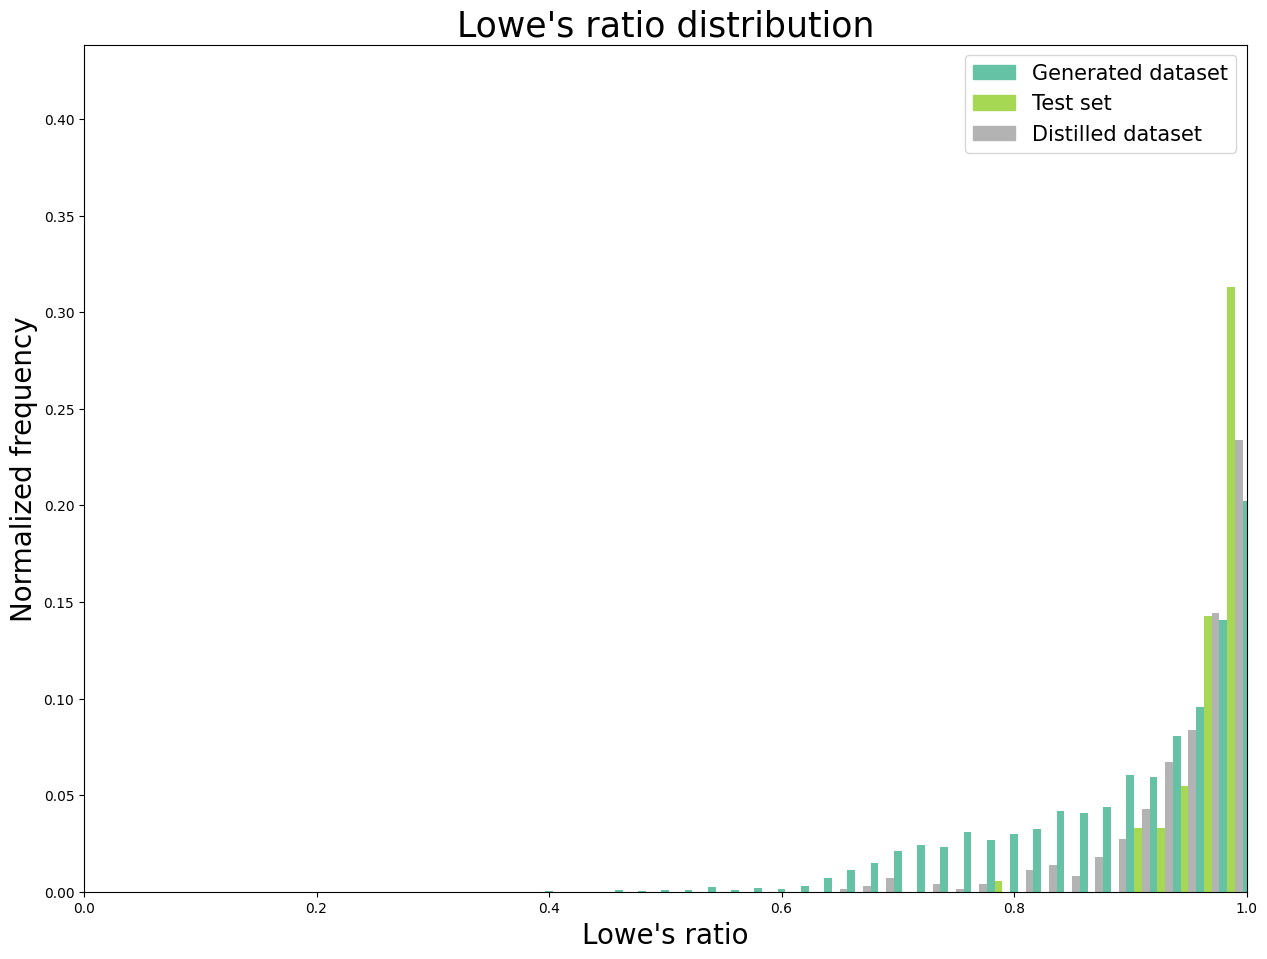

In [77]:
_, dist_test_lr, dist_dist_lr = draw_corr_hist_plot([dataset.input_df.ratio, test_dataset.input_df.ratio, ratio_dist_corr], ['Generated dataset', 'Test set', 'Distilled dataset'], r=(0.0,1), title="Lowe's ratio distribution", xlabel="Lowe's ratio");

In [78]:
jensenshannon(dist_test_lr, dist_dist_lr)

0.2159008972027063

# Latent Filtering

In [79]:
dist_name = 'filt-gen-05'
coeff_latent_filtering = np.load(f'../memorization/stats/{dist_name}-corr.npy')


max_corr_latent_filtering = np.max(np.abs(coeff_latent_filtering), axis=1)

idx = np.abs(coeff_latent_filtering).argsort(axis=1)[:, -2]
second_max_corr_latent_filtering = np.abs(coeff_latent_filtering[np.arange(len(coeff_latent_filtering)), idx])

ratio_latent_filtering = second_max_corr_latent_filtering / max_corr_latent_filtering

coeff_latent_filtering.shape, max_corr_latent_filtering.shape, second_max_corr_latent_filtering.shape, ratio_latent_filtering.shape

((727, 727), (727,), (727,), (727,))

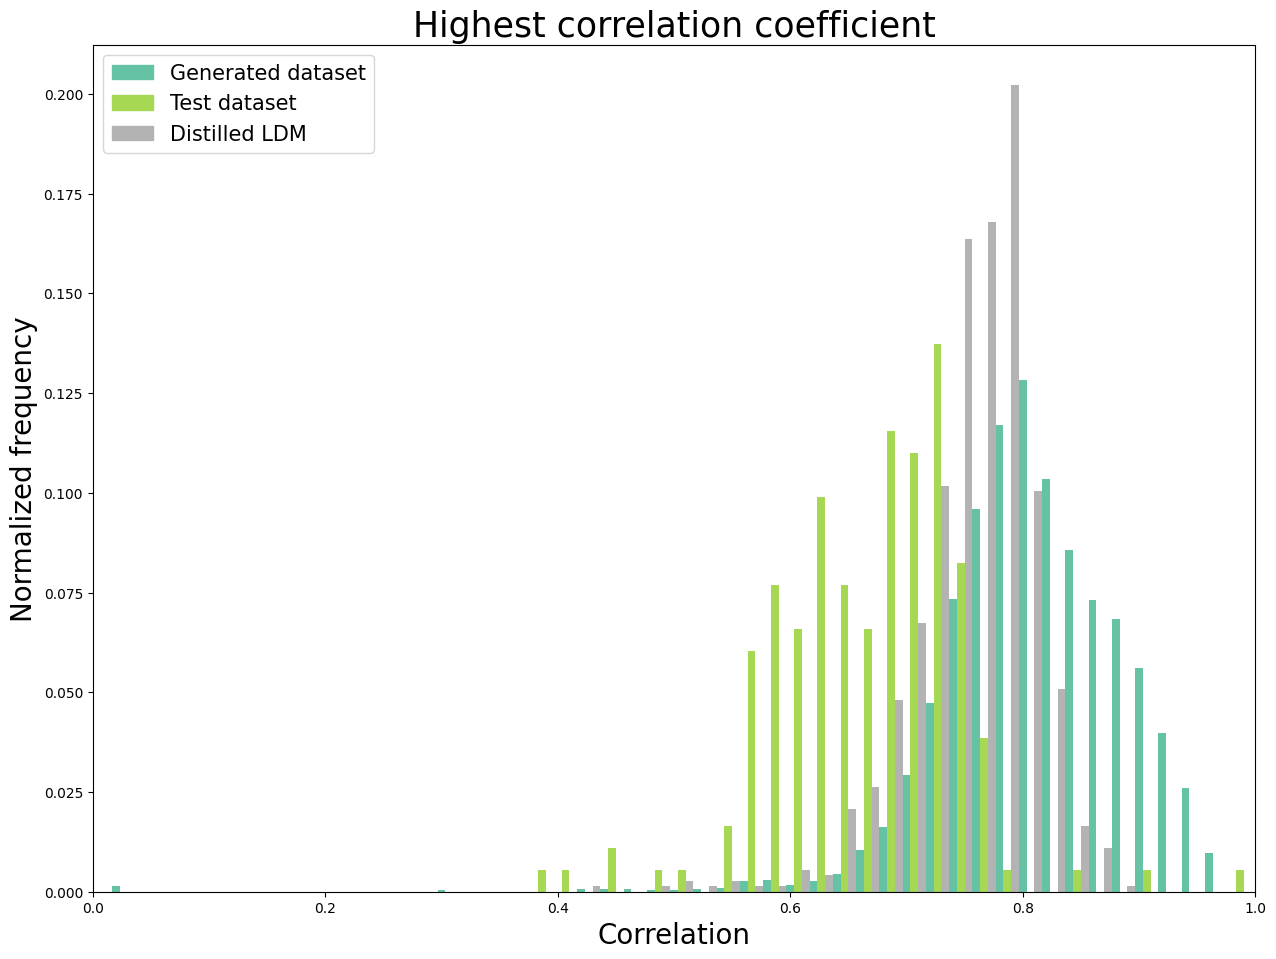

In [80]:
_, _, dist_dist = draw_corr_hist_plot([max_corr_gen, max_corr_test, max_corr_latent_filtering], ['Generated dataset', 'Test dataset', 'Distilled LDM'])

In [81]:
jensenshannon(dist_test, dist_dist)

0.5197968263381325

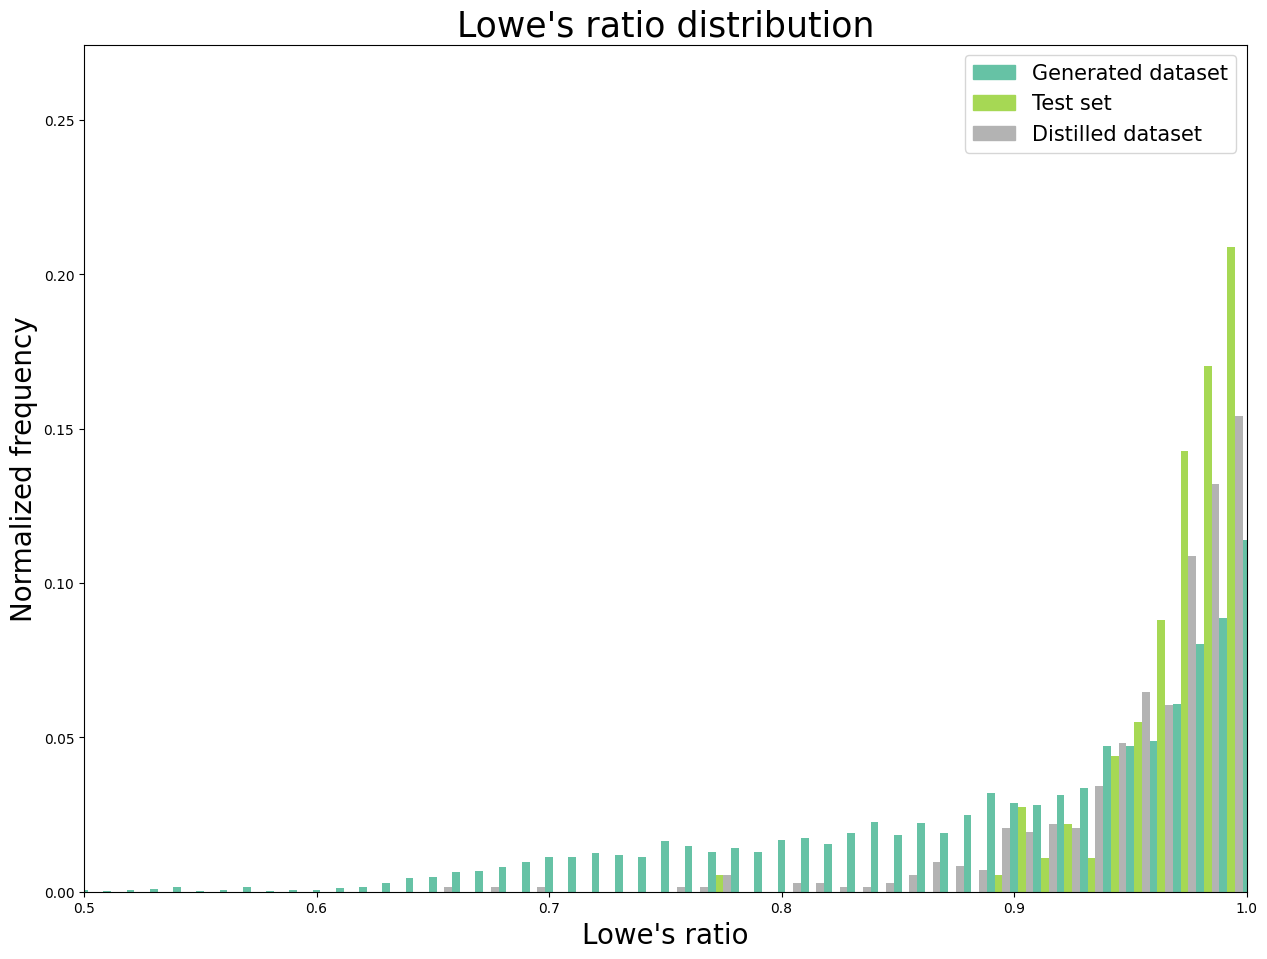

In [82]:
_, dist_test_lr, dist_dist_lr = draw_corr_hist_plot([dataset.input_df.ratio, test_dataset.input_df.ratio, ratio_latent_filtering], ['Generated dataset', 'Test set', 'Distilled dataset'], r=(0.5,1), title="Lowe's ratio distribution", xlabel="Lowe's ratio");

In [83]:
jensenshannon(dist_test_lr, dist_dist_lr)

0.1758940025526692

# Countering memo all together

In [99]:
figsize(30, 11)

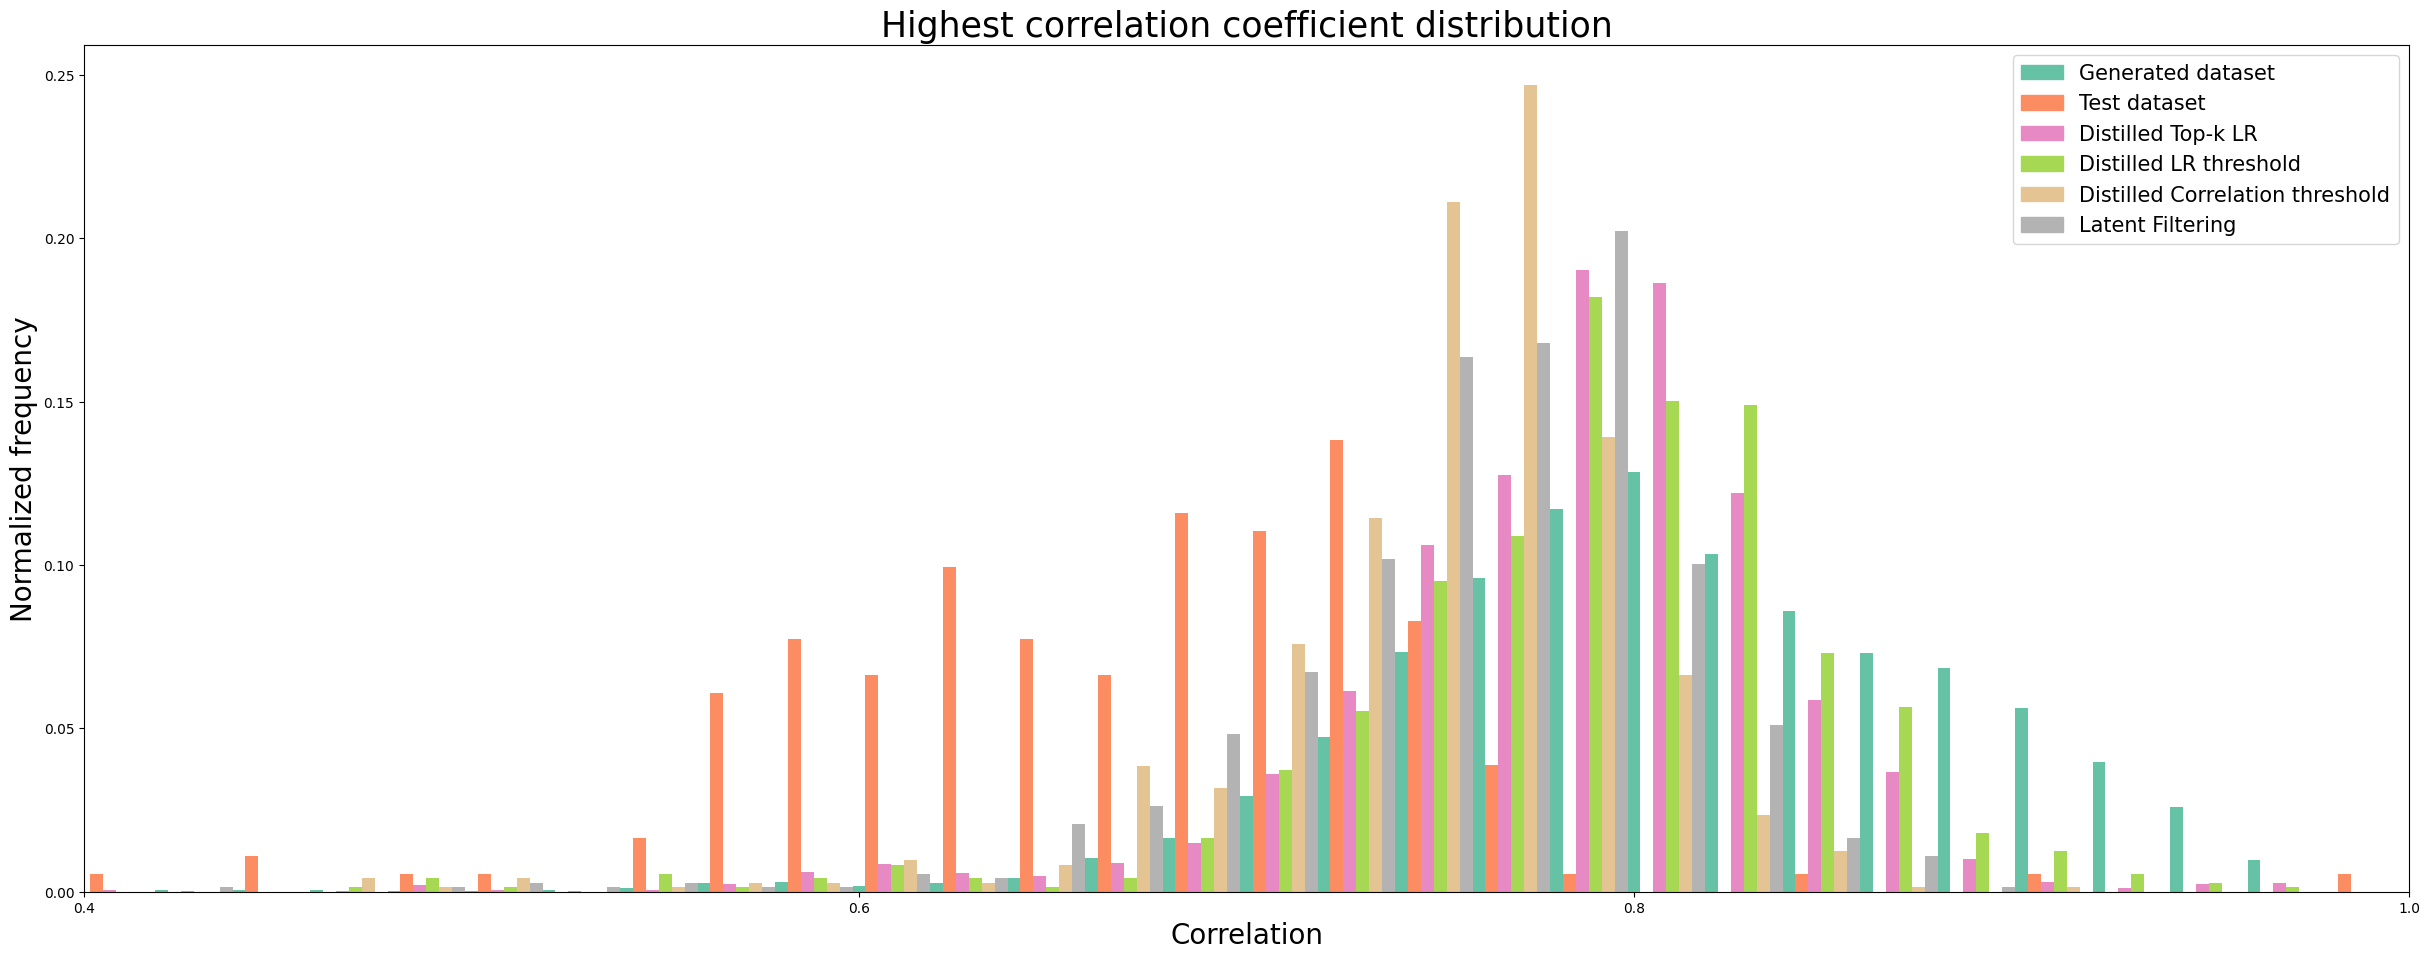

In [103]:
draw_corr_hist_plot([max_corr_gen, max_corr_test, max_corr_dist, max_corr_dist_lrt, max_corr_dist_corr, max_corr_latent_filtering], ['Generated dataset', 'Test dataset', 'Distilled Top-k LR', 'Distilled LR threshold', 'Distilled Correlation threshold', 'Latent Filtering'], title='Highest correlation coefficient distribution', xlabel='Correlation', r=(0.4, 1), step_num=30);

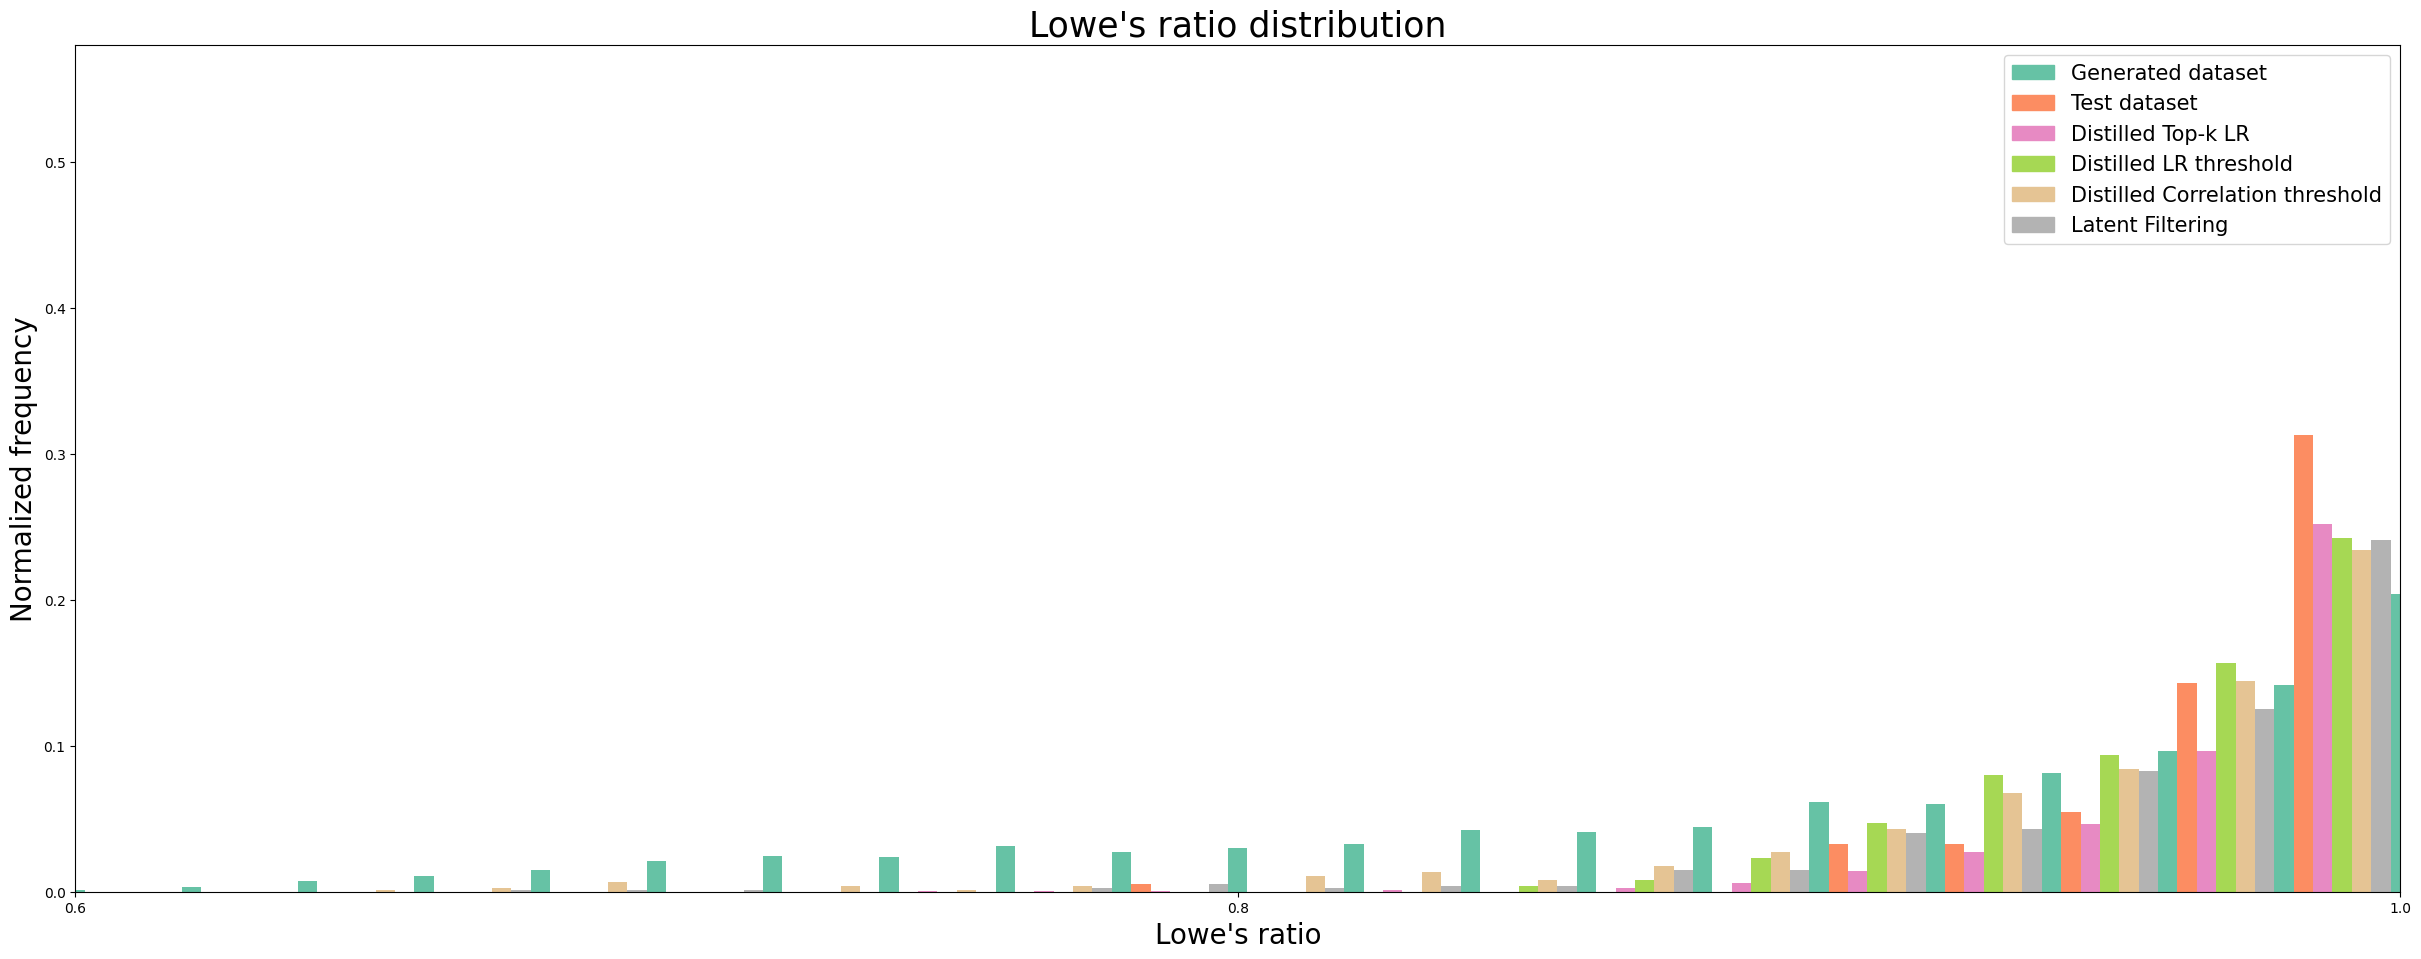

In [96]:
draw_corr_hist_plot([dataset.input_df.ratio, test_dataset.input_df.ratio, ratio_dist, ratio_dist_lrt, ratio_dist_corr, ratio_latent_filtering], ['Generated dataset', 'Test dataset', 'Distilled Top-k LR', 'Distilled LR threshold', 'Distilled Correlation threshold', 'Latent Filtering'], r=(0.6,1), title="Lowe's ratio distribution", xlabel="Lowe's ratio", step_num=20);